In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 2
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
# tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
q = tf.constant([0,2,5,8])
k = tf.constant([0,1,2,3,4,5])
models.relative_position_matrix(image_size=(3, 3), pos_embd_fn=lambda x: x[:, :, None])(q, k)


<tf.Tensor: shape=(4, 6, 2), dtype=int32, numpy=
array([[[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2]],

       [[ 0, -2],
        [ 0, -1],
        [ 0,  0],
        [ 1, -2],
        [ 1, -1],
        [ 1,  0]],

       [[-1, -2],
        [-1, -1],
        [-1,  0],
        [ 0, -2],
        [ 0, -1],
        [ 0,  0]],

       [[-2, -2],
        [-2, -1],
        [-2,  0],
        [-1, -2],
        [-1, -1],
        [-1,  0]]], dtype=int32)>

In [4]:
config = DotMap({
    'ds': 'mnist',
    'distributed': False,
    'shuffle': True,
    'minibatch_size': 24,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': None,
    'display_images': True,
    'display_image_interval': 500,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 1000,
    'mixed_float': False,
    'continuous': False,
    'n_logistic_mix_components': 1,
})

config.discrete = not config.continuous

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

Example integers sampled from gamma distribution.
tf.Tensor(
[334 269 211 379 190  16  21  22  56  51 113 312  52 223  73  60 235 162
  49 191  28 241  83 402 241  47 165 286  50  82  35 236 218 673 444  87
 102  65  34 130 198 274   8 489  67 286 200  79 133 150  19 132 272 113
  82  23 255  50 172  85 270  50  52 783 234  40 135  45  13  11  52 190
 266 260 179  38 279 280 256  61 142  77  22  15 541 171 433 222 266  46
  65 280 144 172 235 653  37 128 132  20], shape=(100,), dtype=int32)
Init 1/3 with method k-means++
Inertia for init 1/3: 0.7470511434713965
Init 2/3 with method k-means++
Inertia for init 2/3: 0.7733025341776898
Init 3/3 with method k-means++
Inertia for init 3/3: 1.3728872438654631
Minibatch step 1/100: mean batch inertia: 0.0009253897828553742
Minibatch step 2/100: mean batch inertia: 0.0009865928239591183, ewa inertia: 0.0009865928239591183
Minibatch step 3/100: mean batch inertia: 0.0008722624409689474, ewa inertia: 0.0008722624409689474
Minibatch step 4/100: me

Not using gradient accumulation


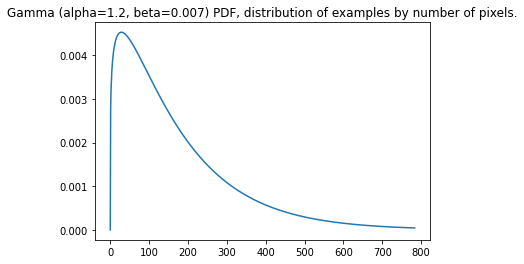

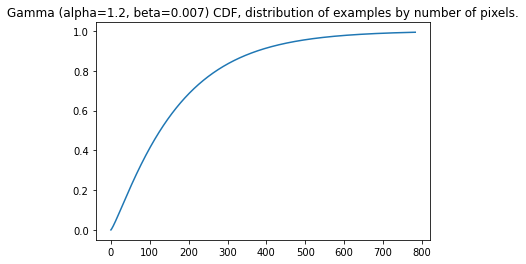

In [5]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_16': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
        'rescale': (16, 16),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'celeb': {
        'name': 'celeb_a',
        'buffer_size': 10000,
        'n_colors': 16,
        'n_color_dims': 3,
        'image_size': (218, 178),
        'rescale': (32, 39),
    }
})

config.dataset = ds_configs[config.ds]
config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
datasets.plot_distribution(config, gamma_dist, gamma_name)

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


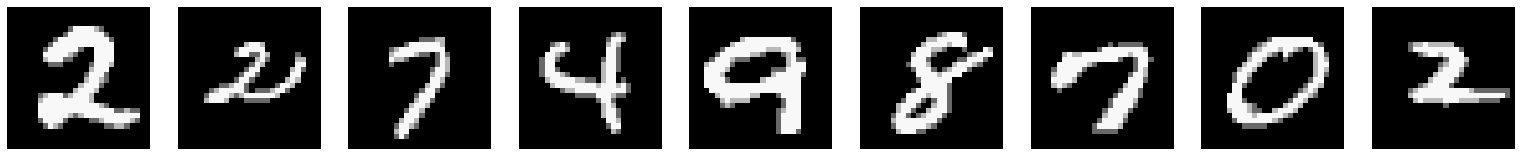

In [6]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.grad_accum_steps:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
if config.continuous:
    display_colors = ds.reinvent_color_dim(display_colors)
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, do_unquantize=config.discrete, max_images=9)

In [7]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'image_size': config.dataset.image_size,
    'seq_len': config.dataset.image_size[0] * config.dataset.image_size[1],
    'n_enc_a_layers': 3,
    'n_enc_b_layers': 3,
    'ffl_dim': 512,
    'embd_dim': 256,
    'n_dec_layers': 2,
    'dec_dim': 400,
    'n_heads': 8,
    'dropout_rate': 0.1,
    'use_idxs_input': True,
    'architecture': 'deberta_anp',
    'position_embedding': 'pos_enc',
    'use_relative_positions': False,
    'activation': 'swish',
    'n_logistic_mix_components': config.n_logistic_mix_components
})

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config))

if config.distributed:
    ds_train = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'full_combination'

import socket
model_name = models.model_name(config)
print(model_name)
# model.summary()

cuda3-bs1x1x24


In [8]:
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-Wq9zJYZB-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall:24", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall:23", shape=(None, 256), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall:25", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-Wq9zJYZB-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall_1:24", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall_1:23", shape=(None, 256), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall_1:25", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. 

Step 0, Loss (last minibatch): 2.1627800464630127, Loss (80 step avg.): 2.1627800464630127


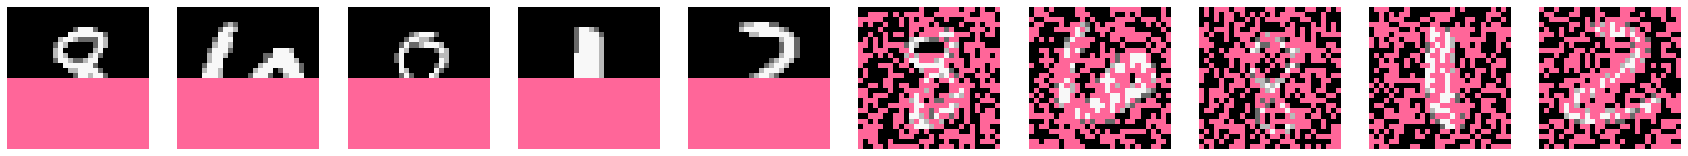

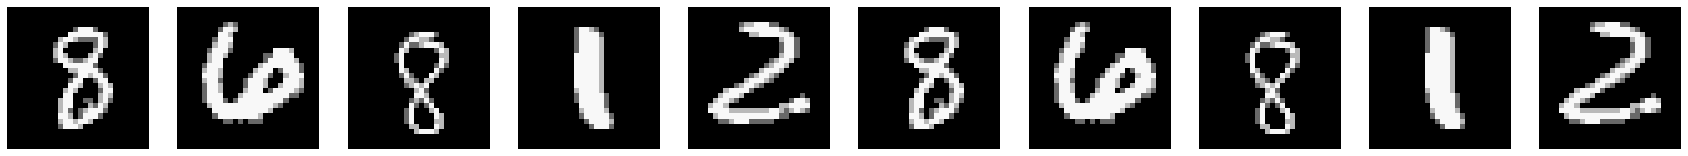

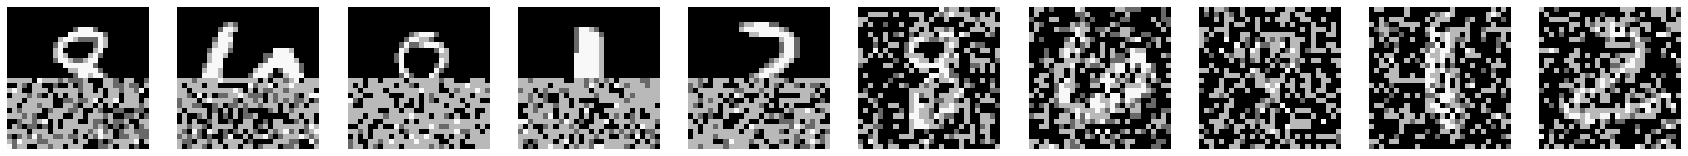

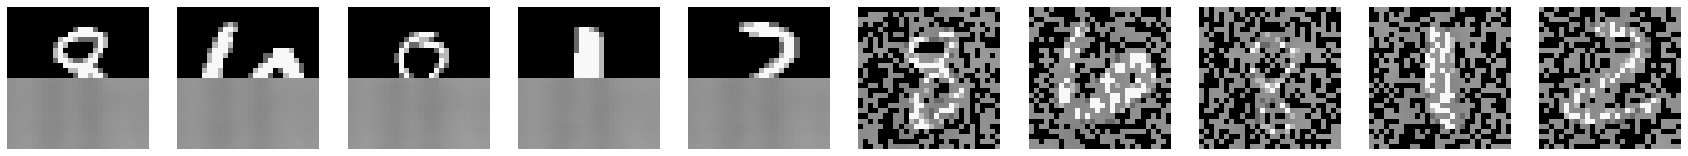

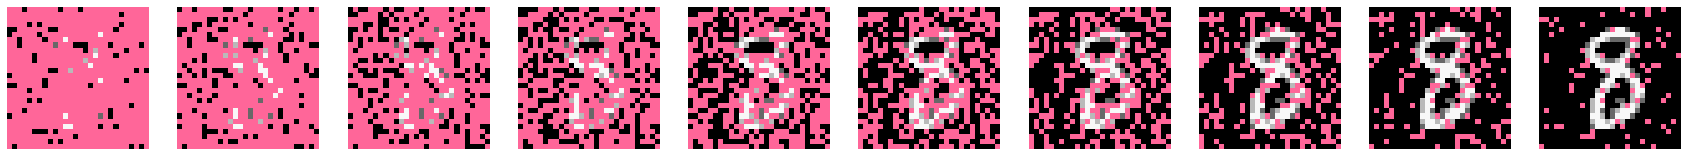

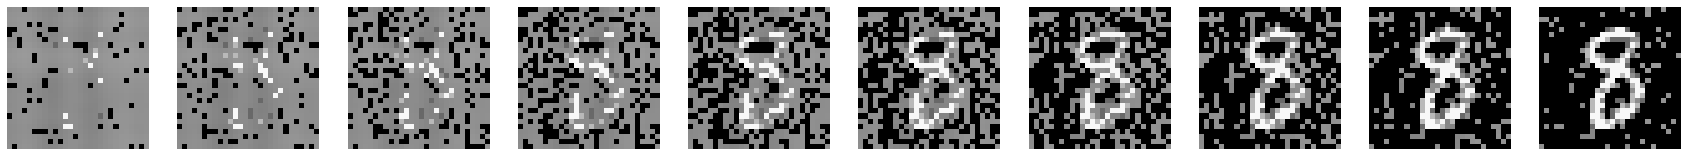

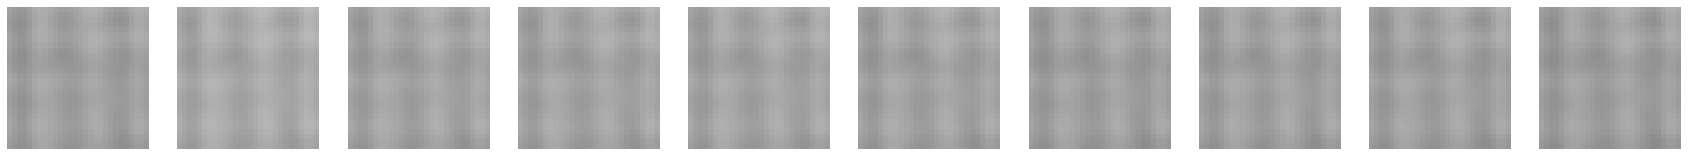

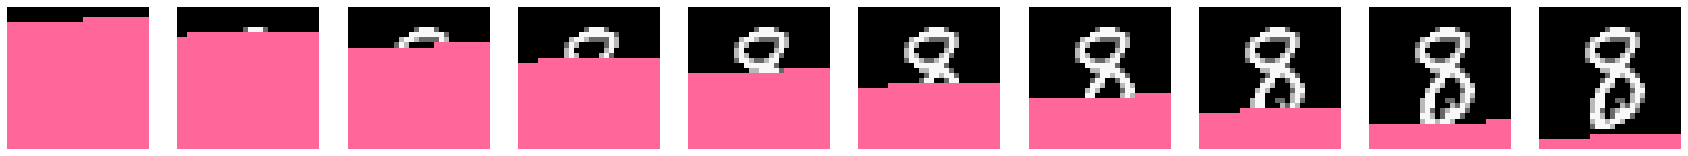

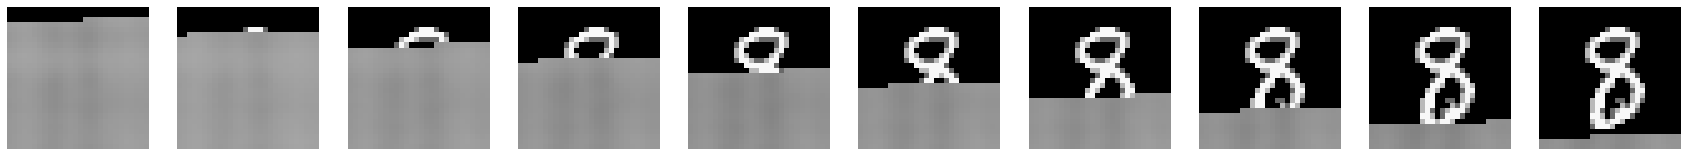

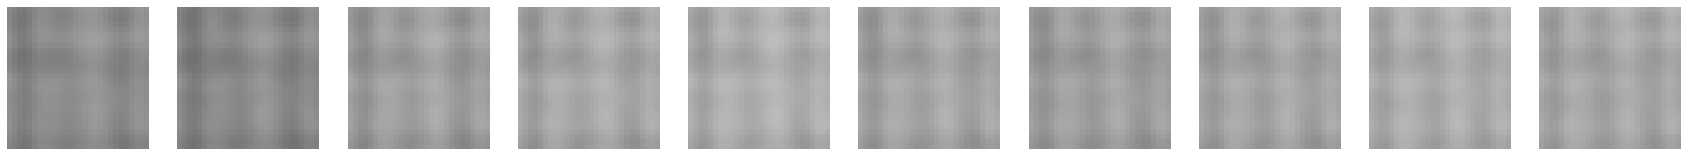

wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step 108, Loss (last minibatch): 0.4695236086845398, Loss (80 step avg.): 0.4783608817759855


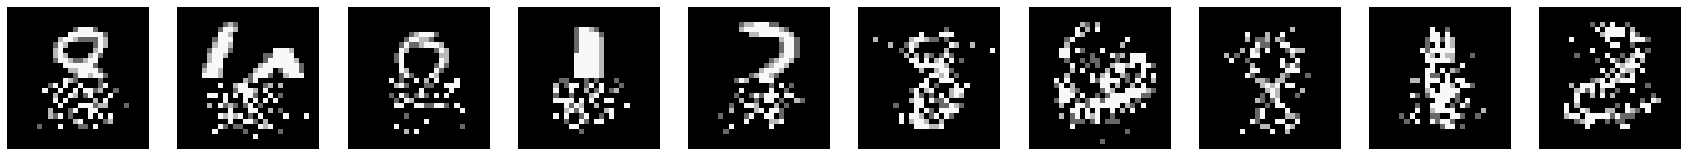

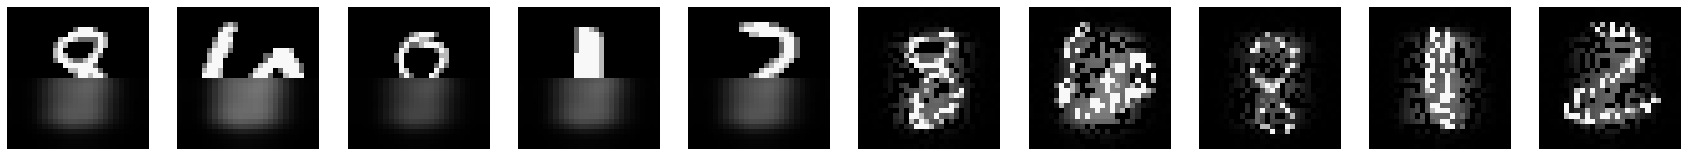

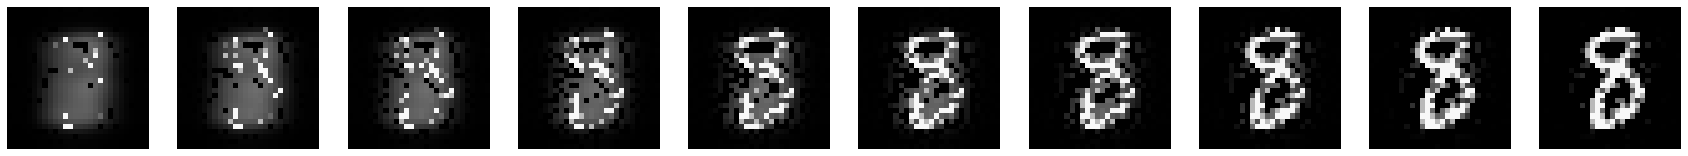

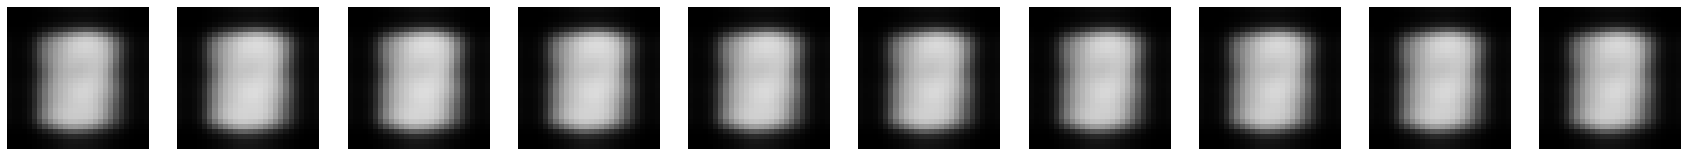

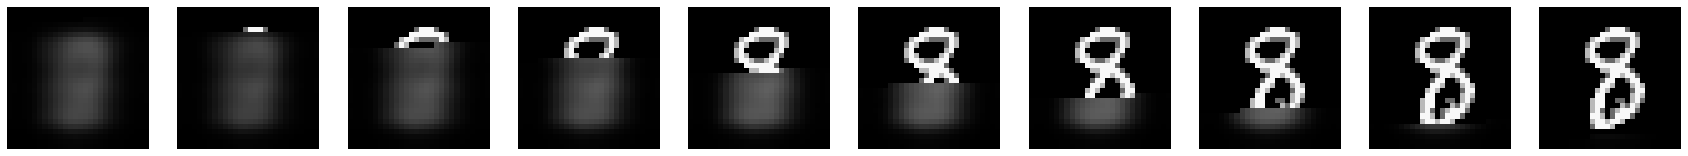

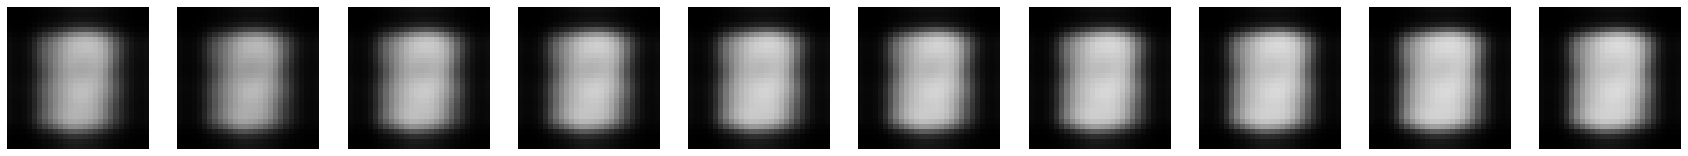

Step 312, Loss (last minibatch): 0.42630261182785034, Loss (80 step avg.): 0.4302138226267732


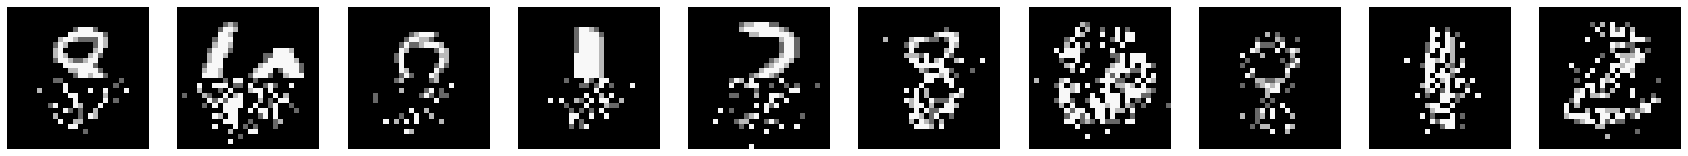

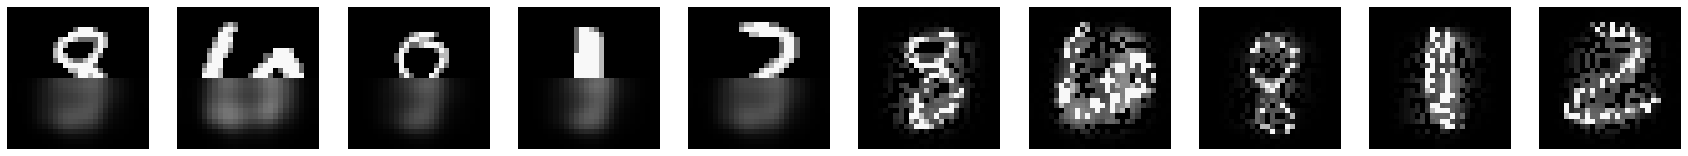

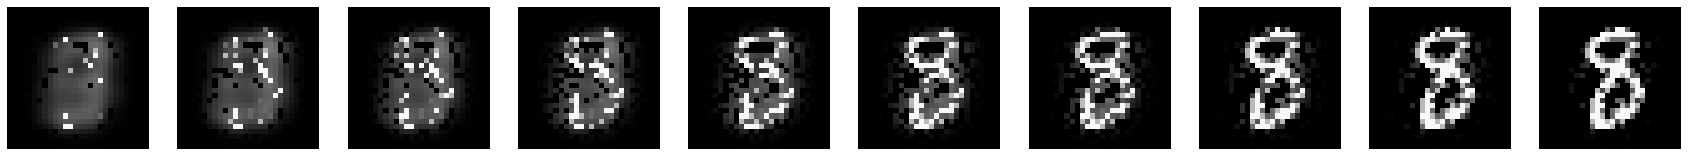

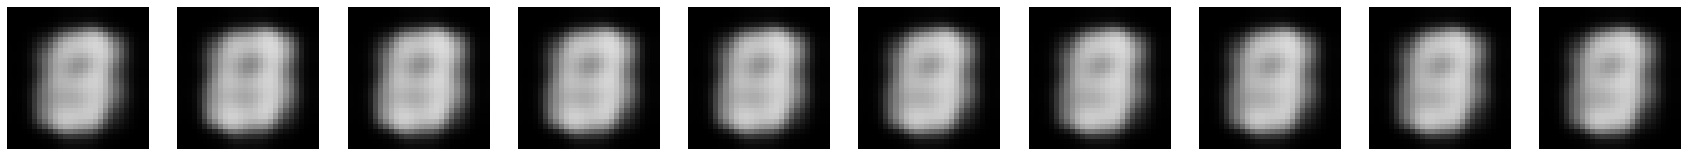

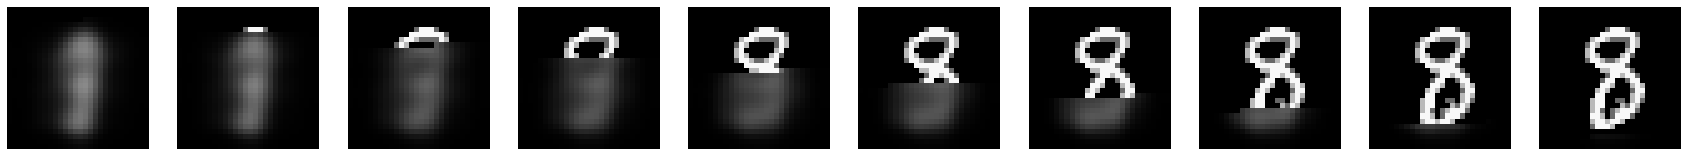

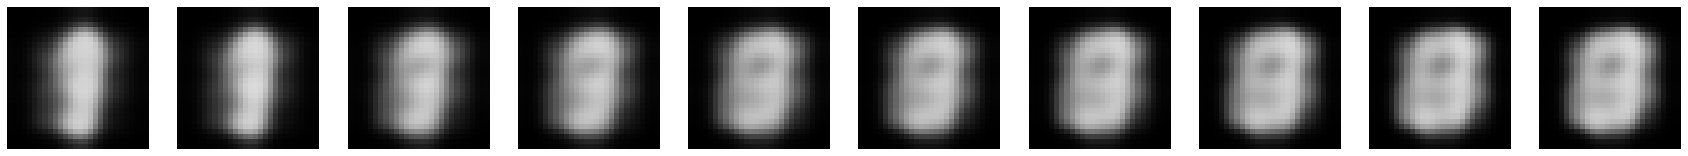

Step 812, Loss (last minibatch): 0.3660324215888977, Loss (80 step avg.): 0.39755481150415206


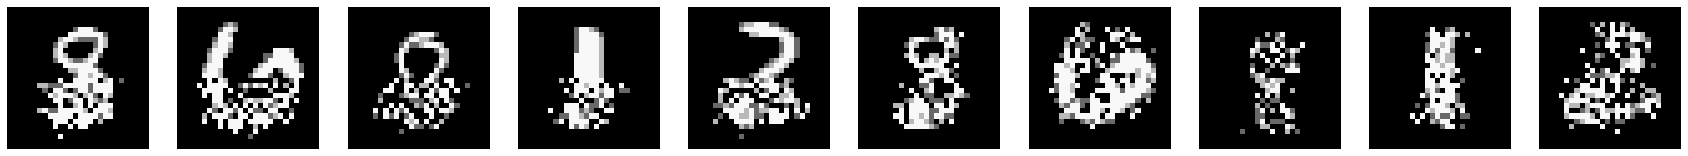

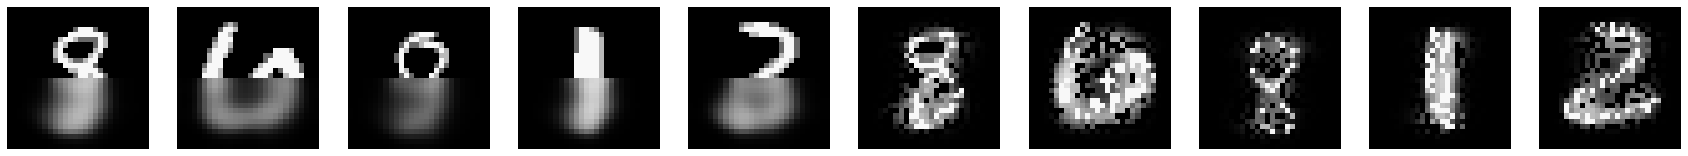

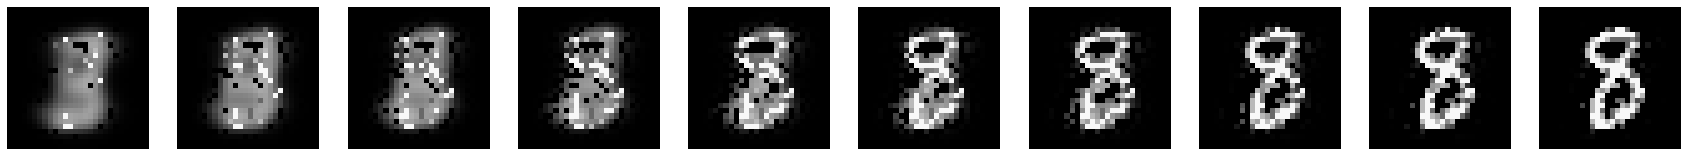

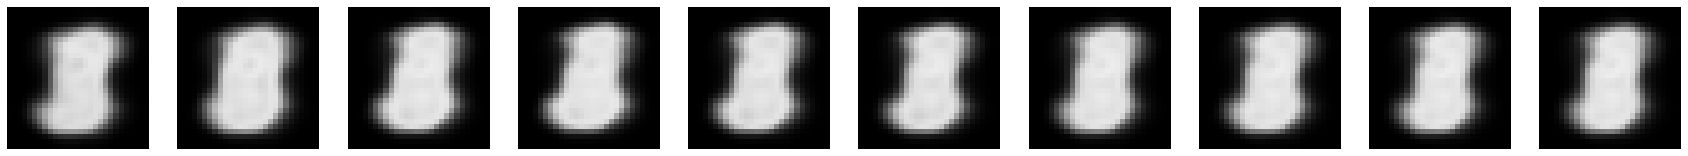

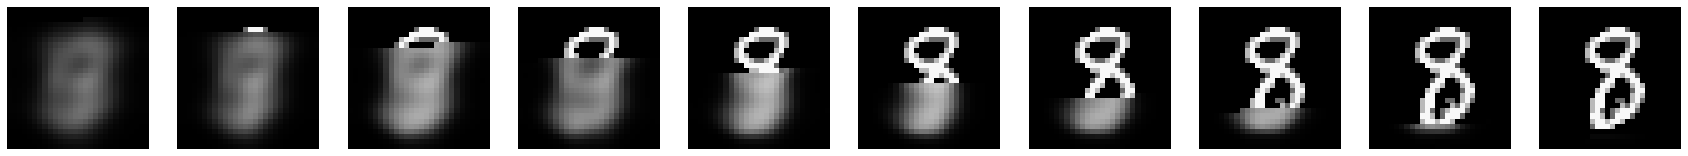

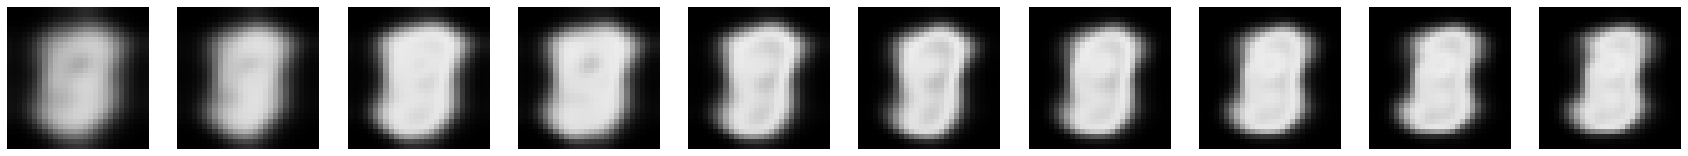

Step 1312, Loss (last minibatch): 0.3311663269996643, Loss (80 step avg.): 0.36752282984462786


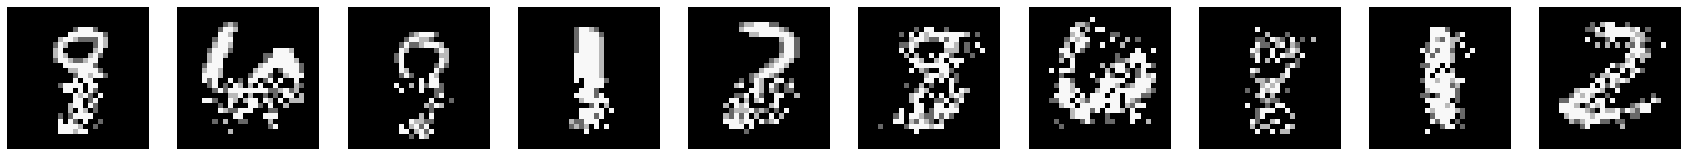

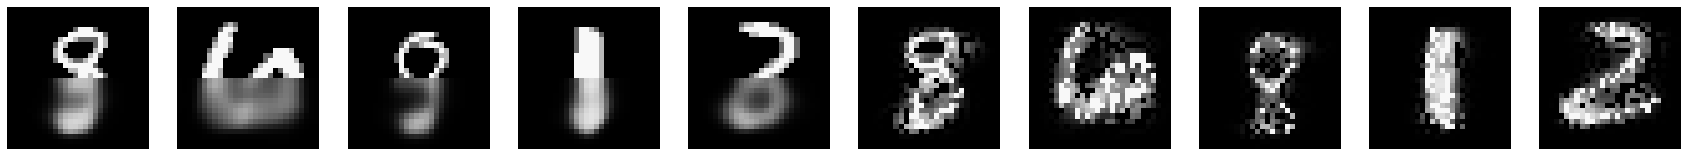

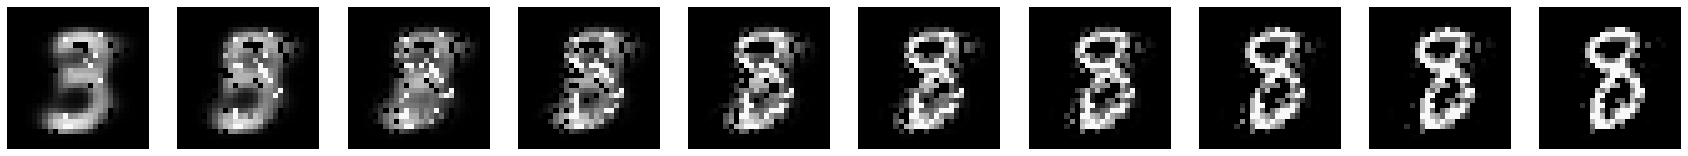

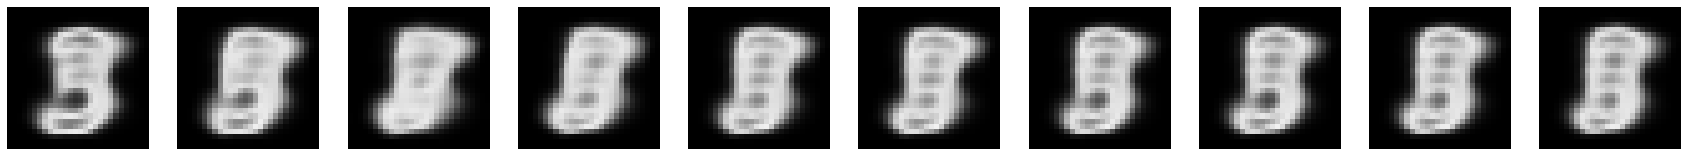

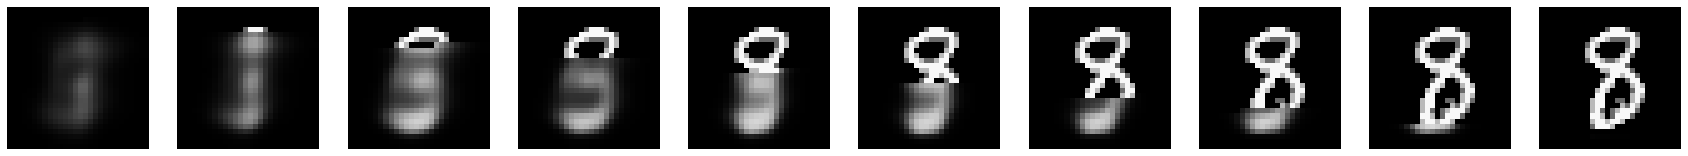

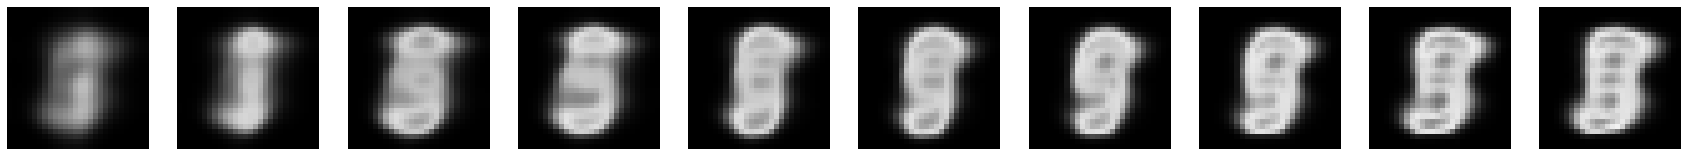

Step 1812, Loss (last minibatch): 0.36472392082214355, Loss (80 step avg.): 0.3319629732473397


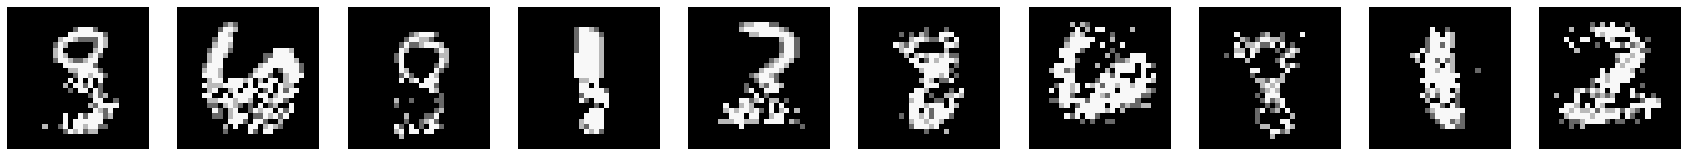

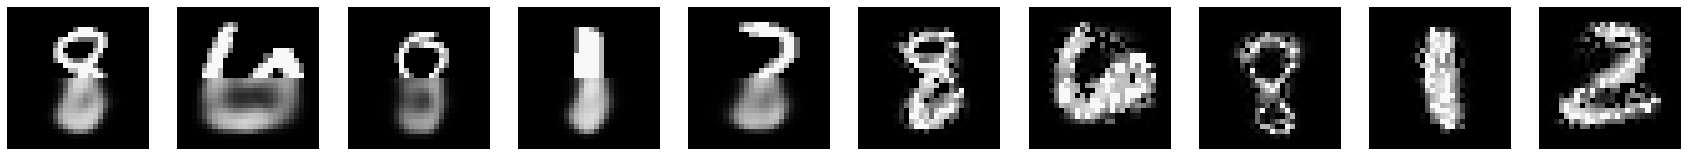

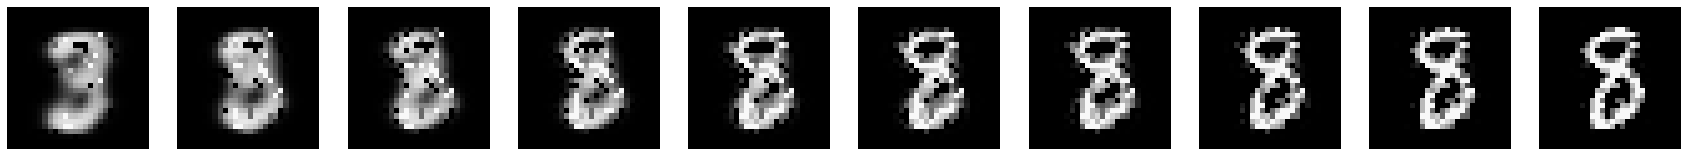

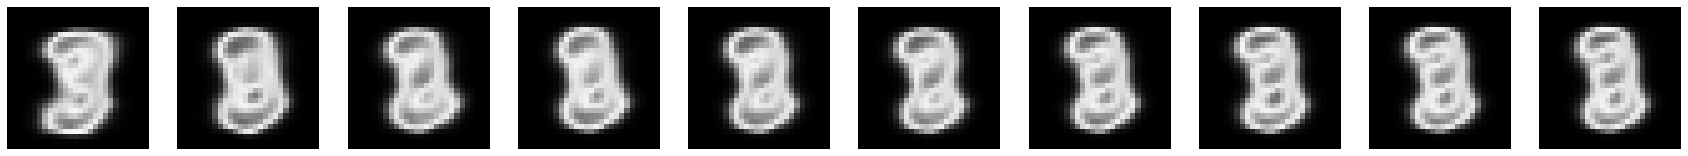

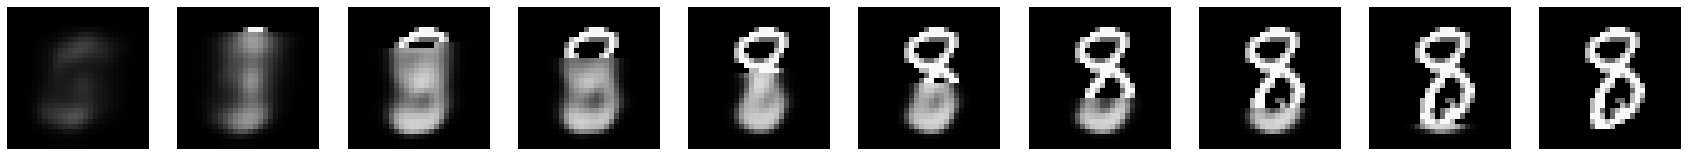

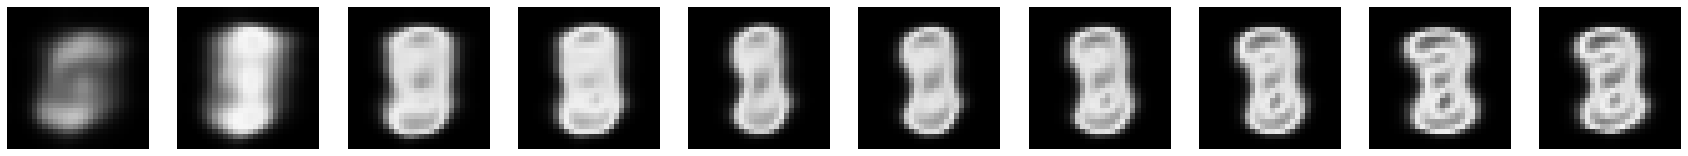

Step 2312, Loss (last minibatch): 0.27452731132507324, Loss (80 step avg.): 0.30826918725614194


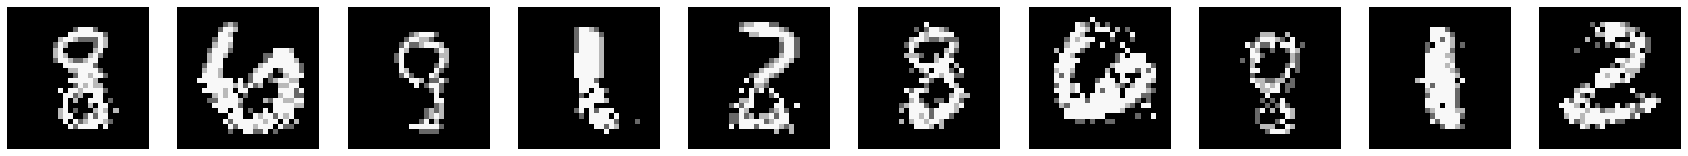

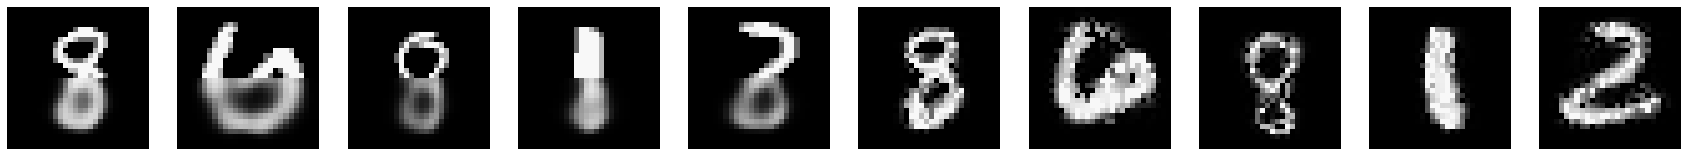

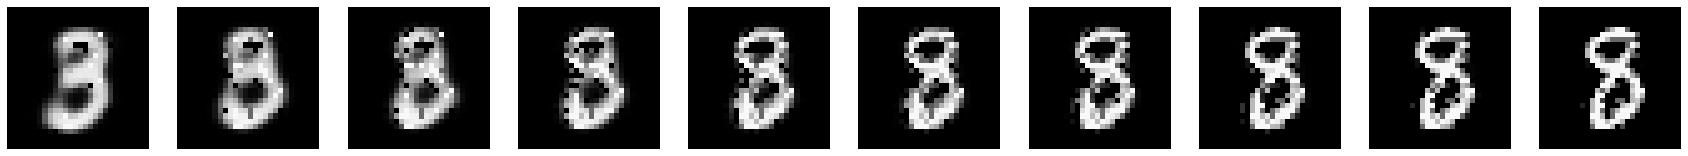

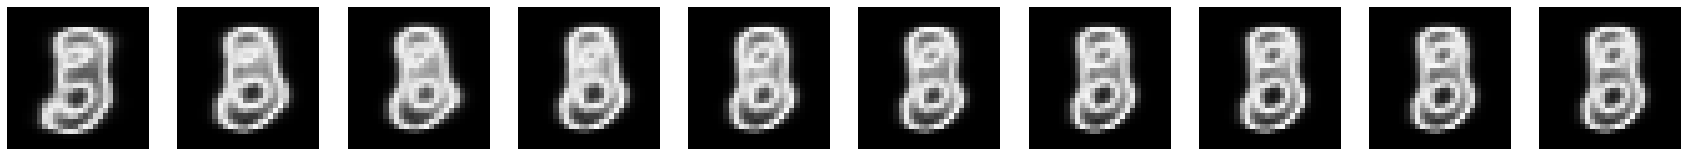

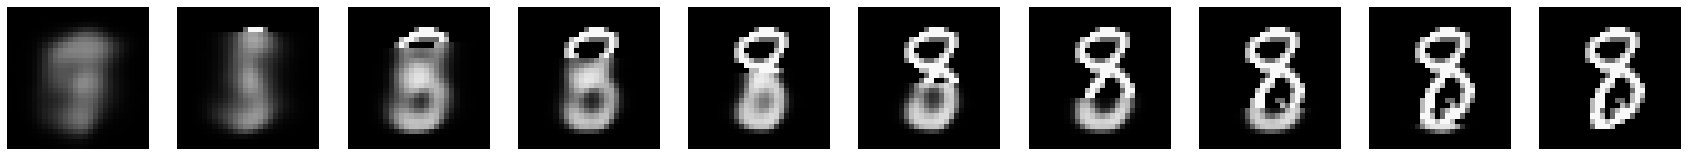

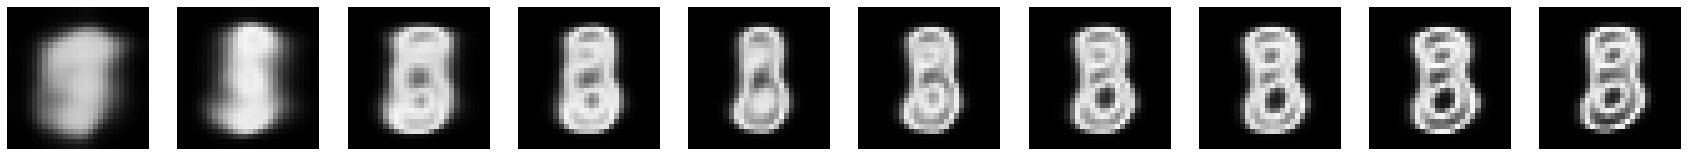

Step 2812, Loss (last minibatch): 0.3520635962486267, Loss (80 step avg.): 0.292964811678286


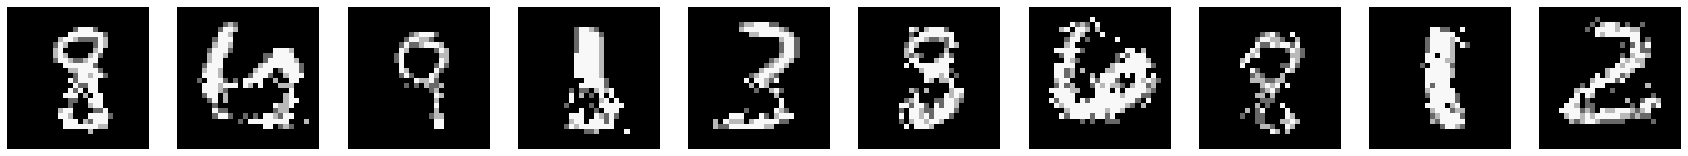

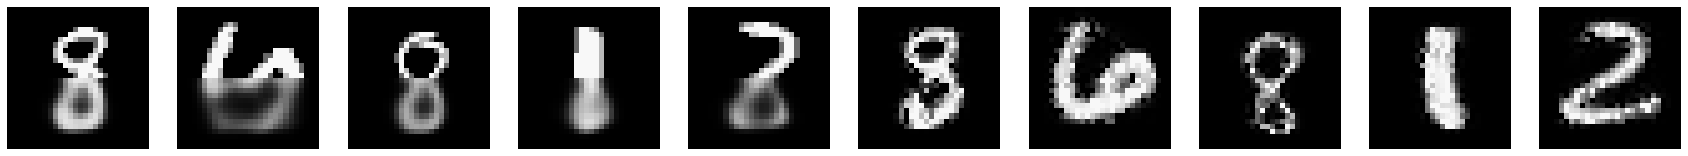

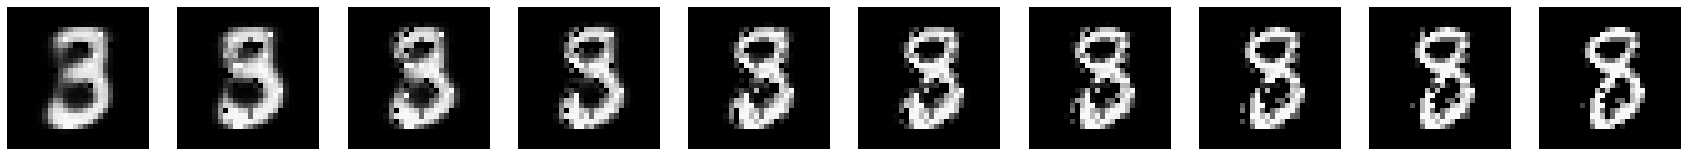

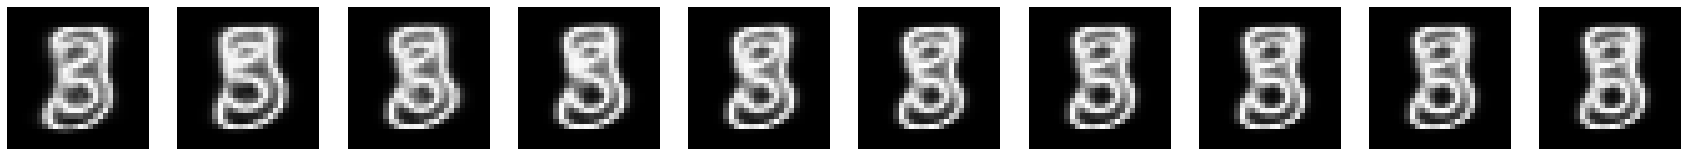

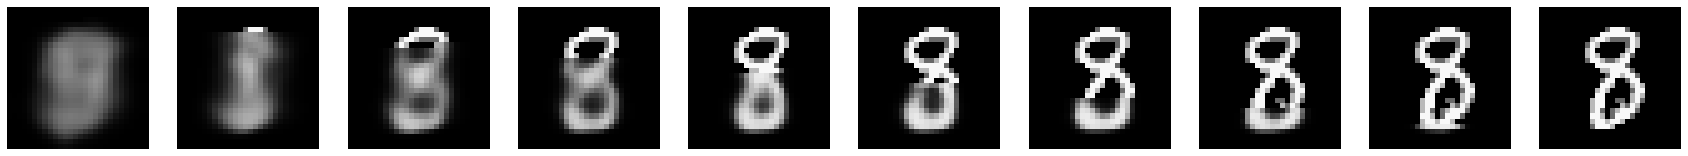

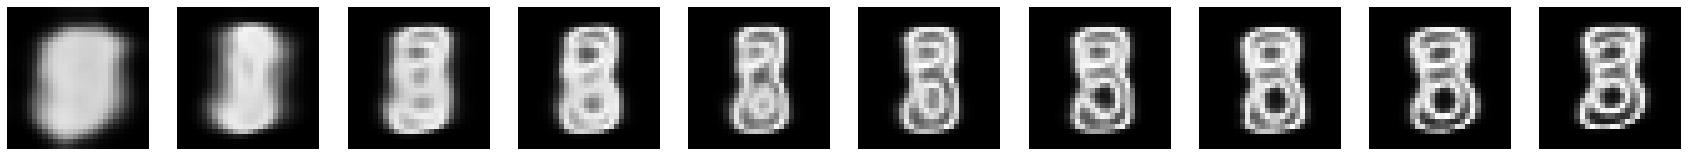

Step 3312, Loss (last minibatch): 0.27359849214553833, Loss (80 step avg.): 0.27618904742929673


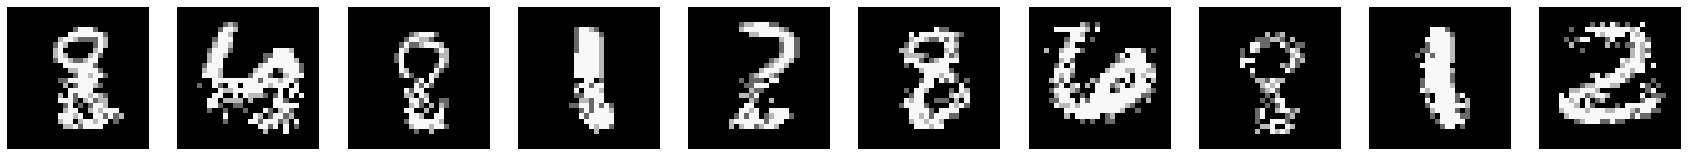

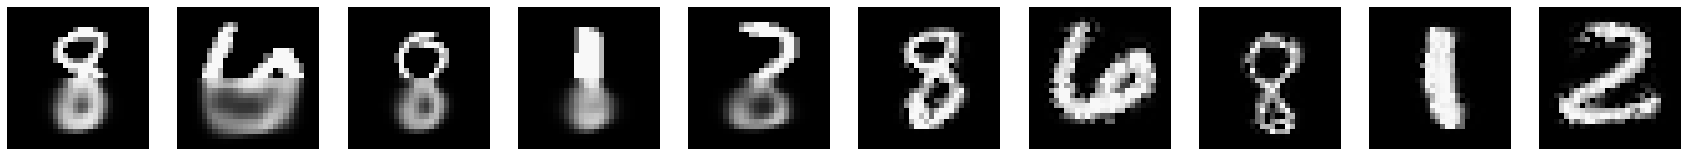

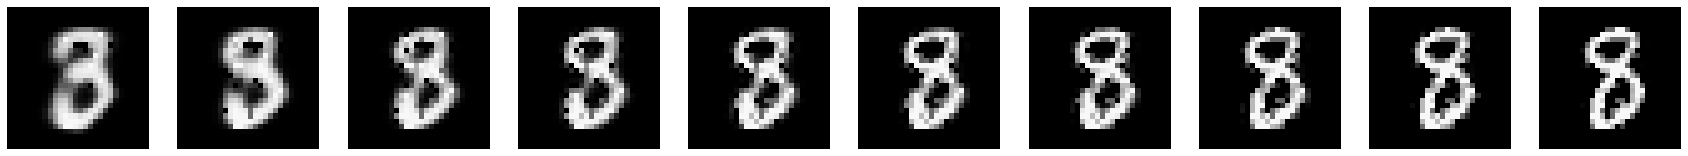

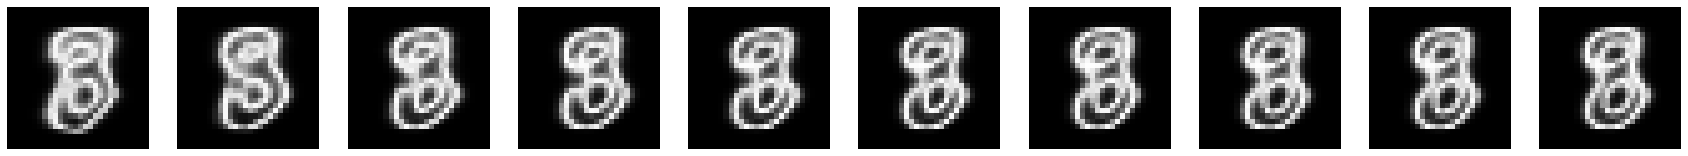

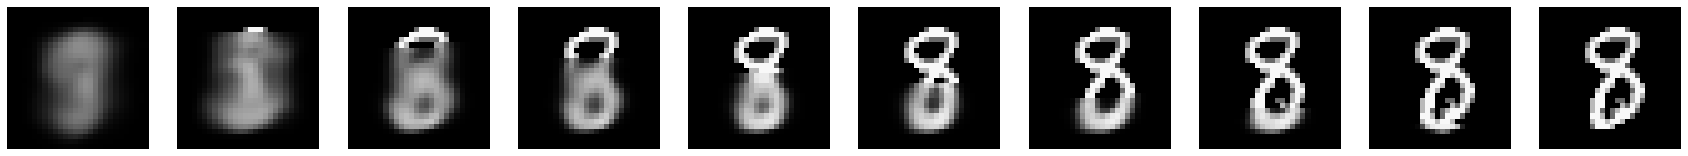

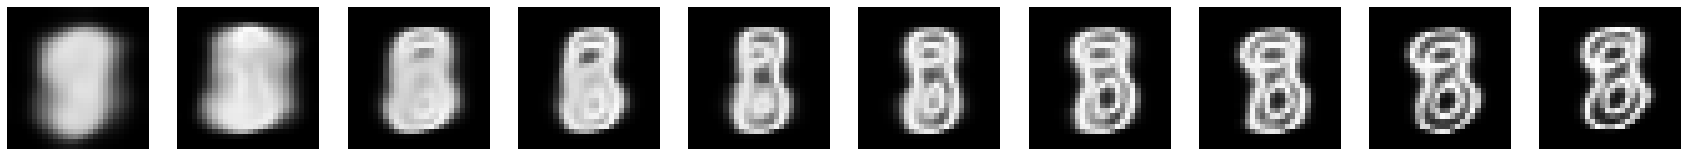

Step 3812, Loss (last minibatch): 0.25570350885391235, Loss (80 step avg.): 0.2685914760754432


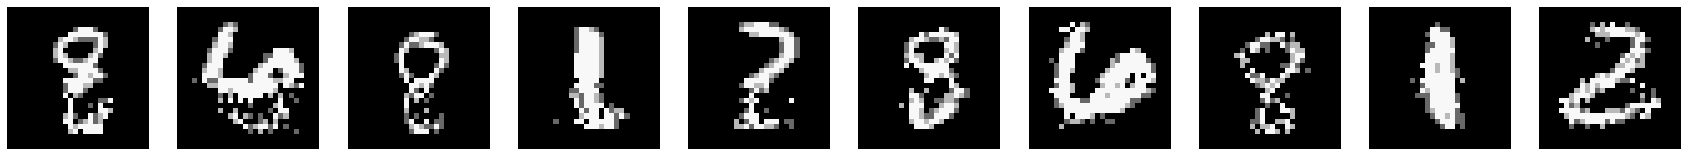

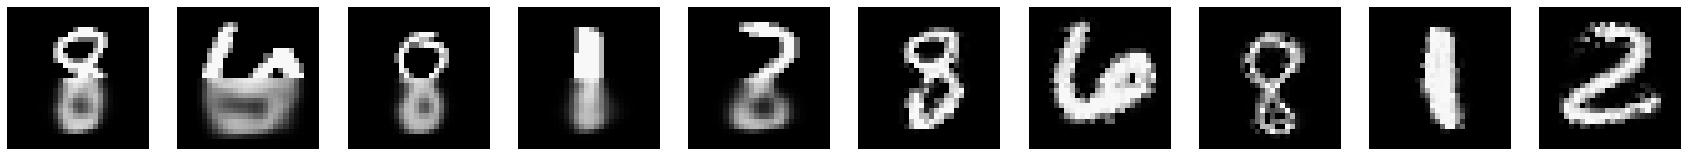

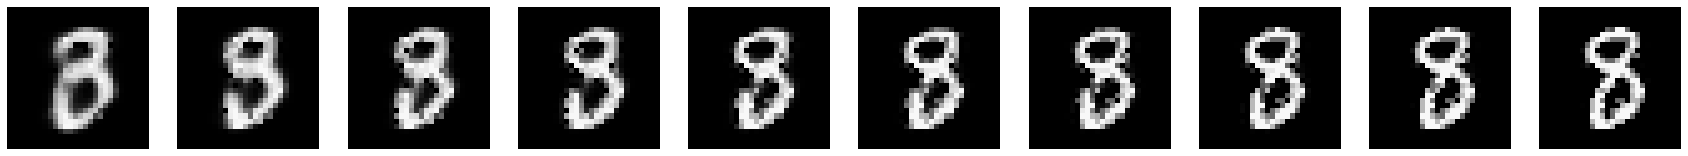

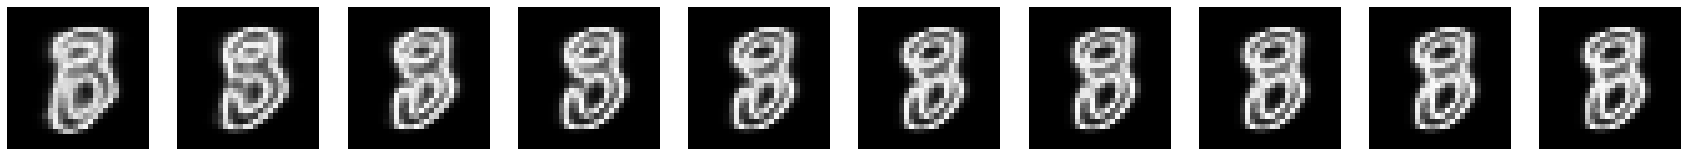

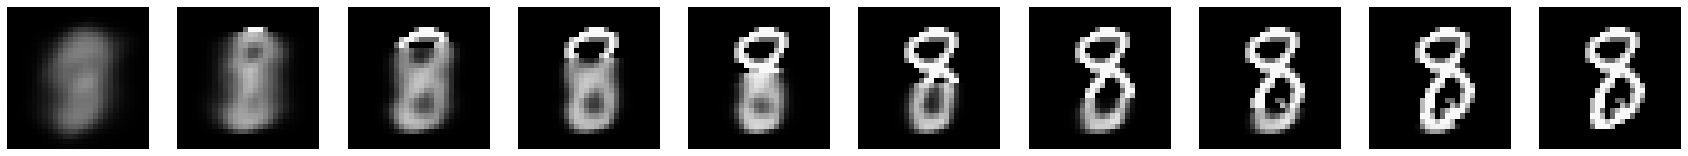

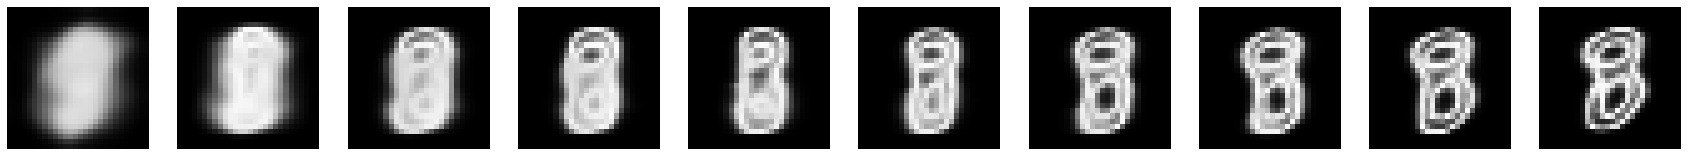

Step 4312, Loss (last minibatch): 0.22861605882644653, Loss (80 step avg.): 0.2580198441390638


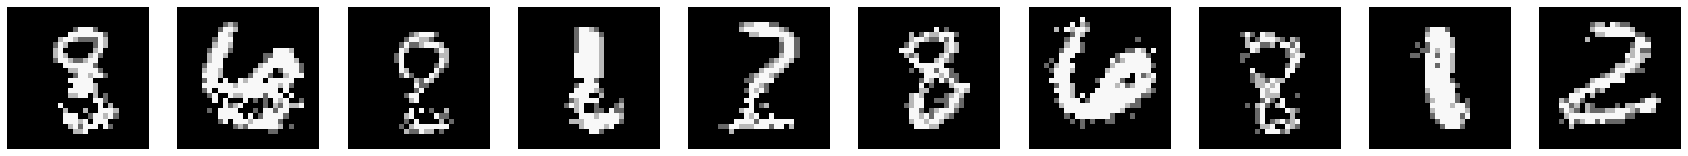

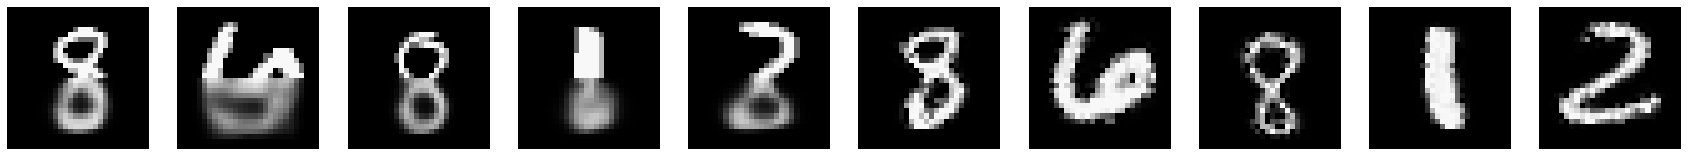

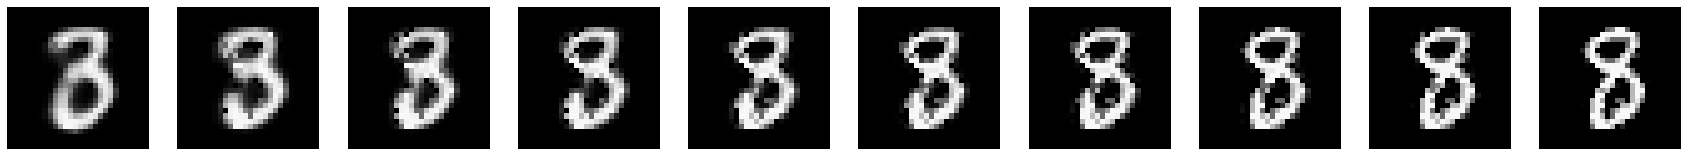

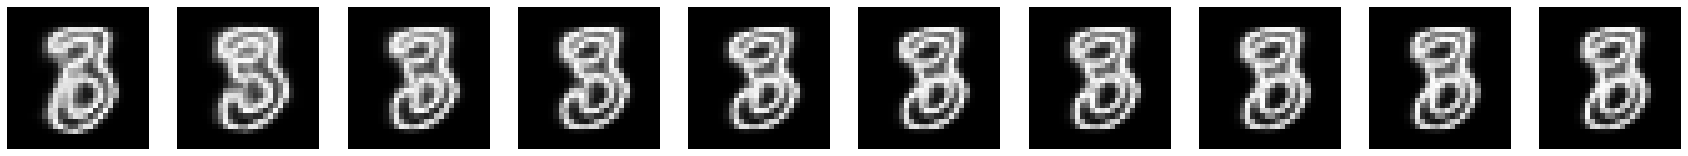

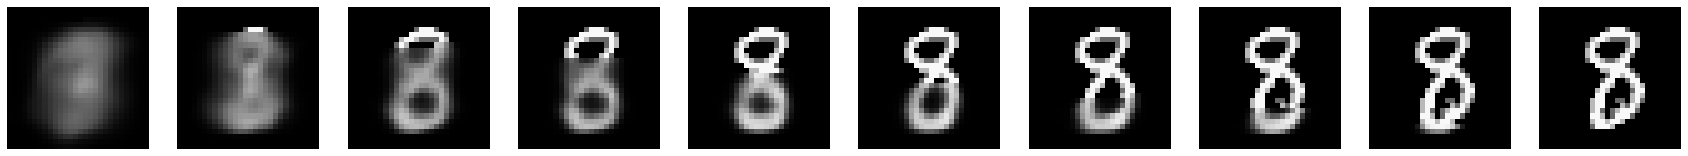

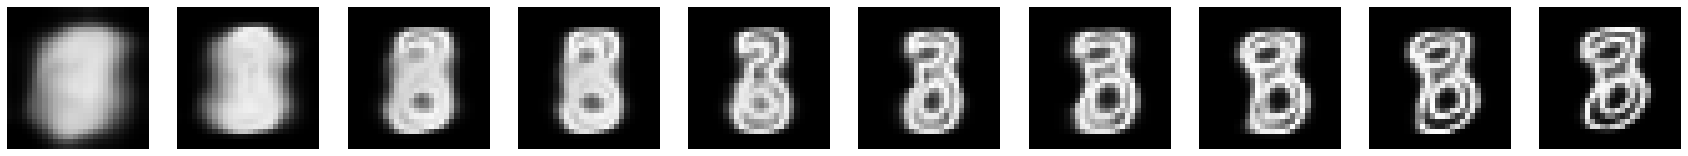

Step 4812, Loss (last minibatch): 0.2447894960641861, Loss (80 step avg.): 0.2581626037020742


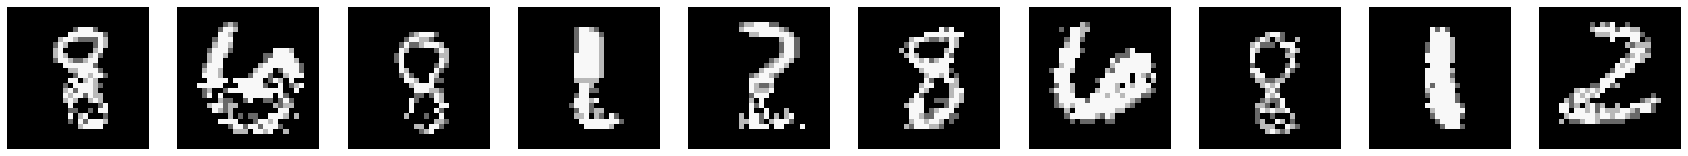

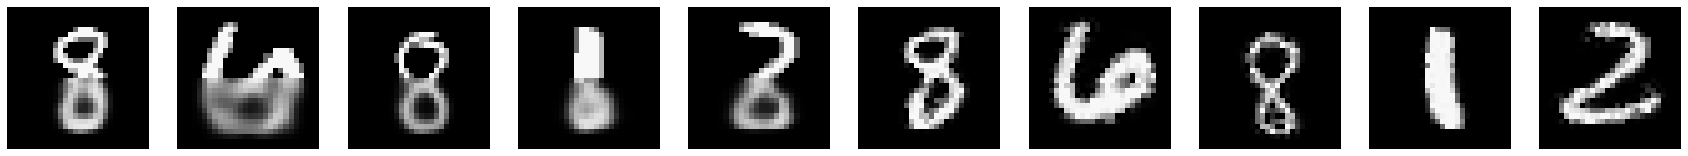

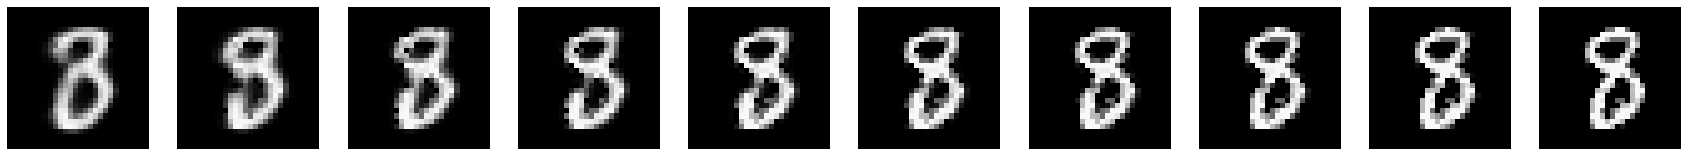

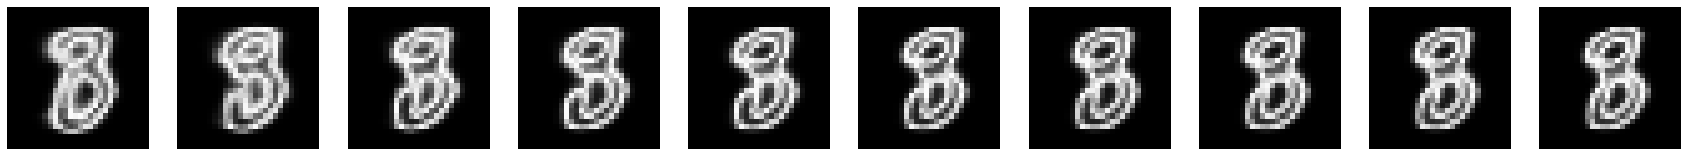

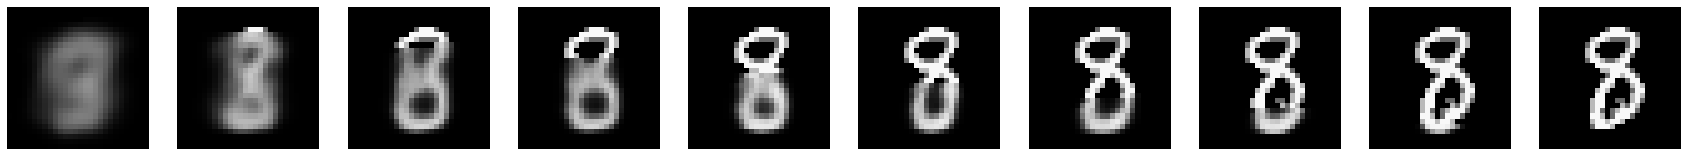

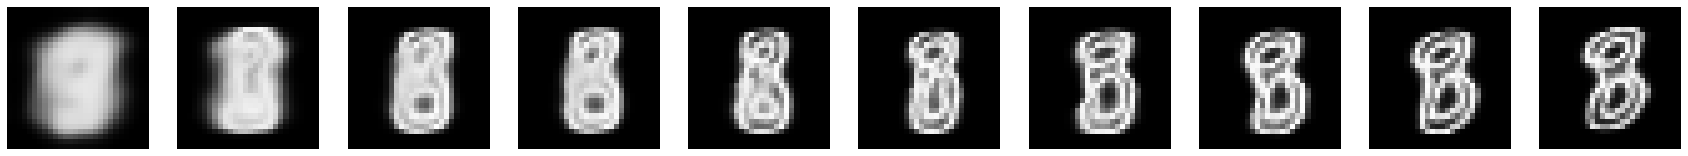

Step 5312, Loss (last minibatch): 0.2911563515663147, Loss (80 step avg.): 0.25020467701517507


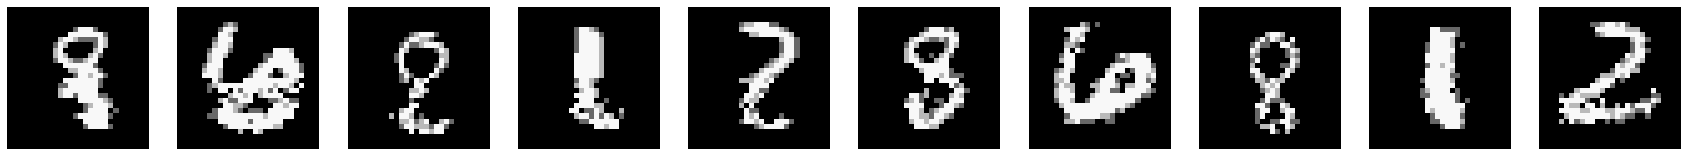

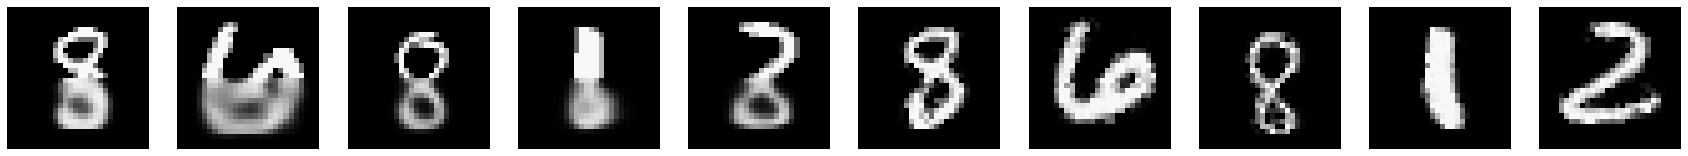

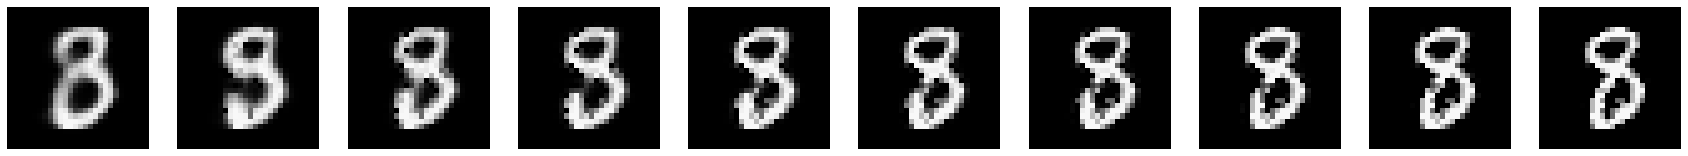

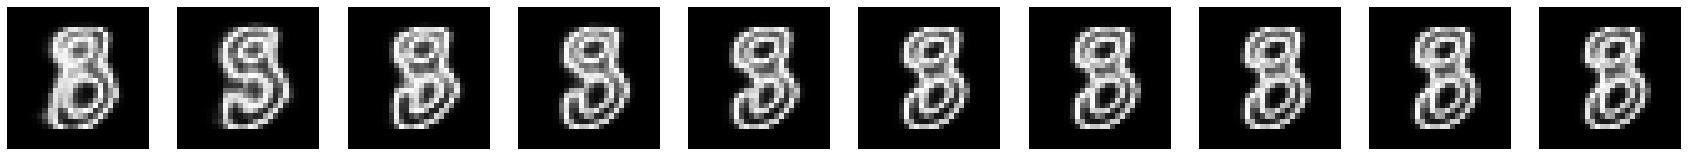

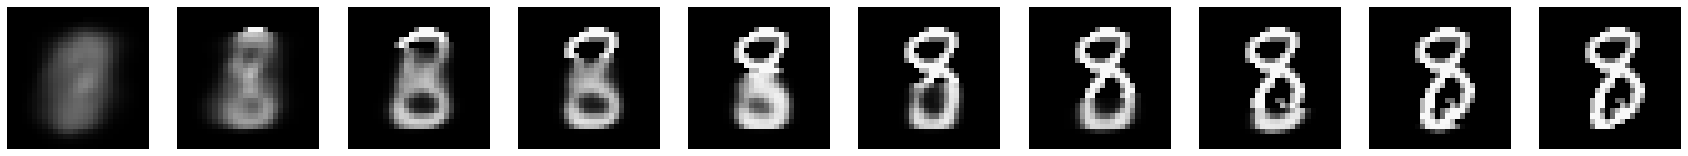

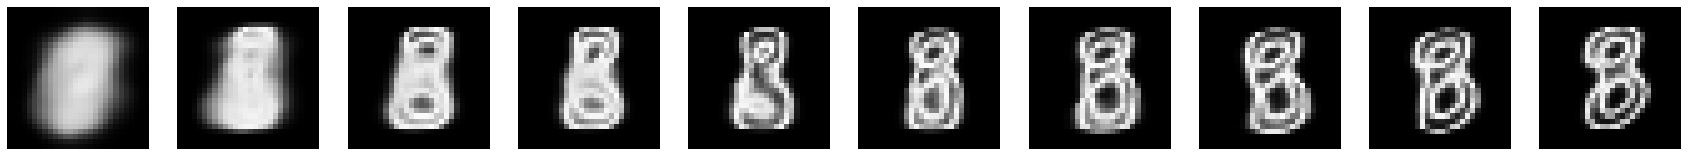

Step 5812, Loss (last minibatch): 0.25550633668899536, Loss (80 step avg.): 0.2491247280512327


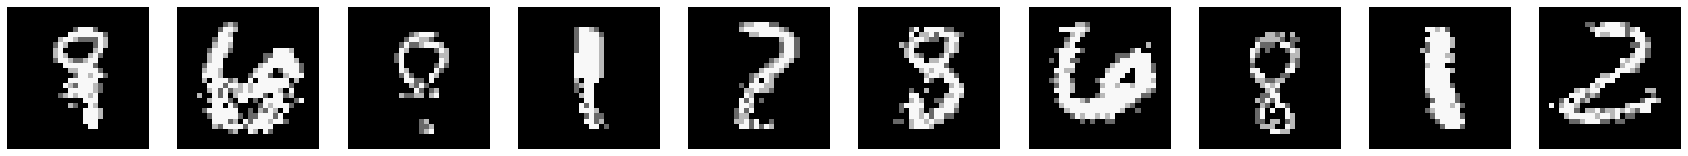

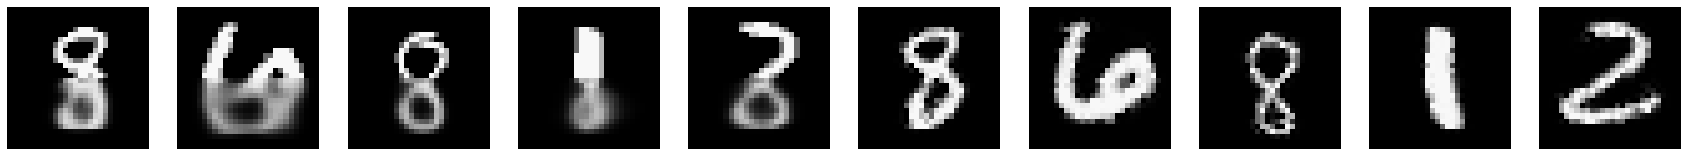

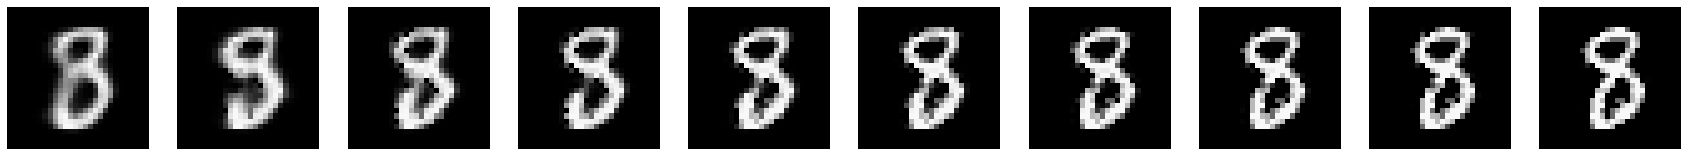

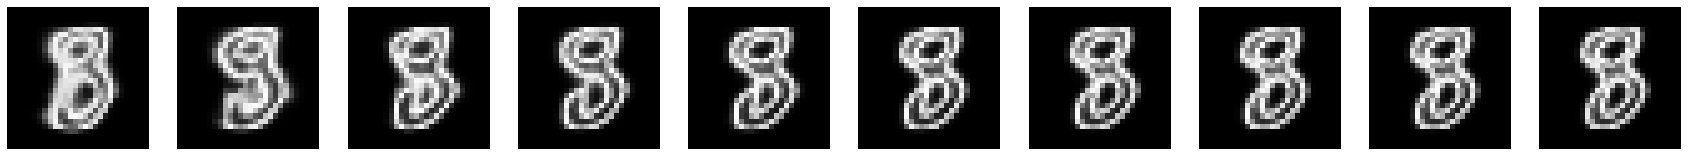

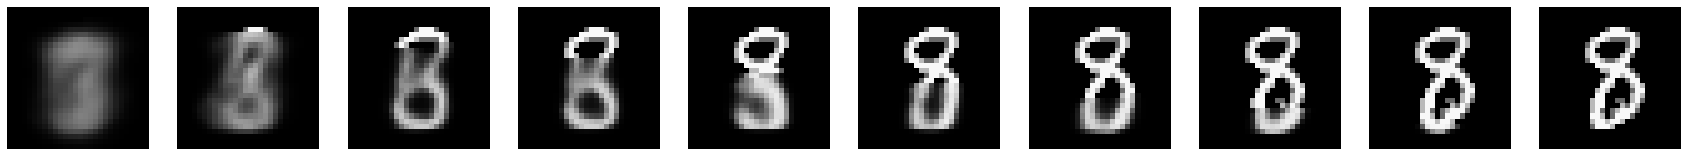

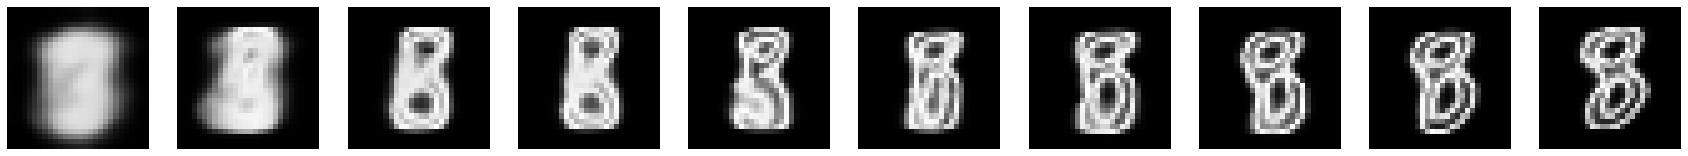

Step 6312, Loss (last minibatch): 0.26654958724975586, Loss (80 step avg.): 0.24032131794058245


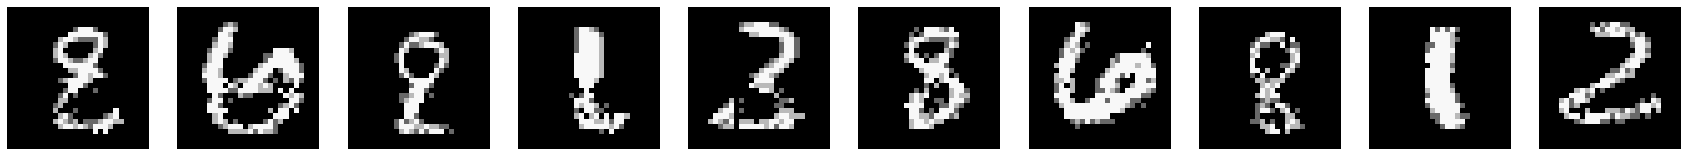

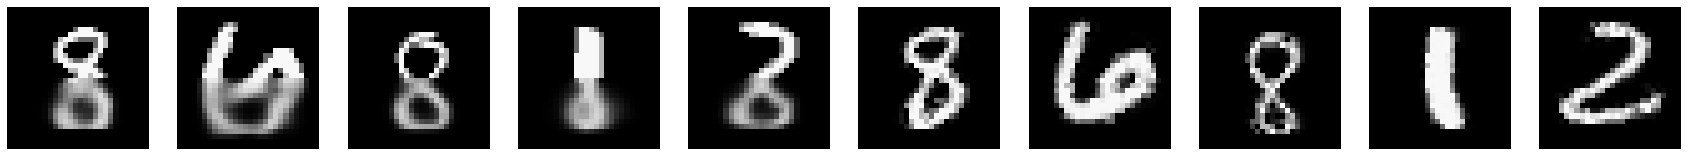

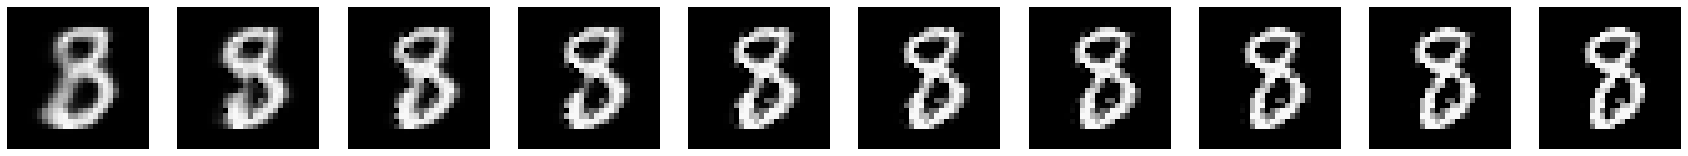

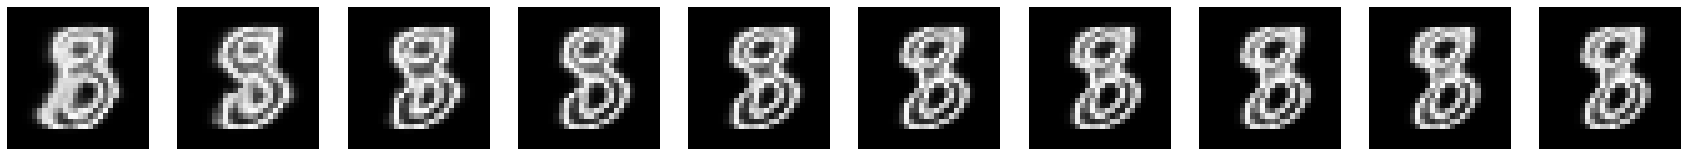

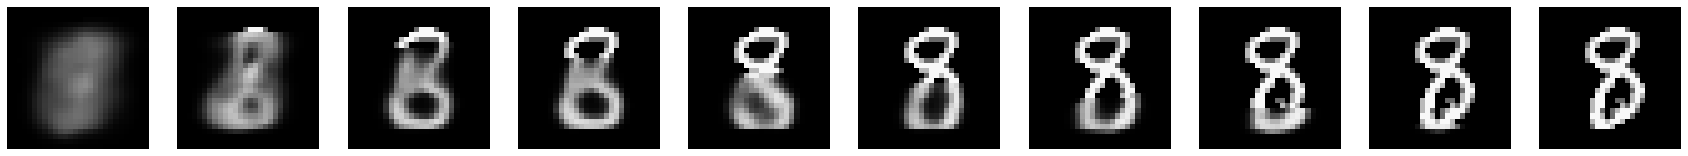

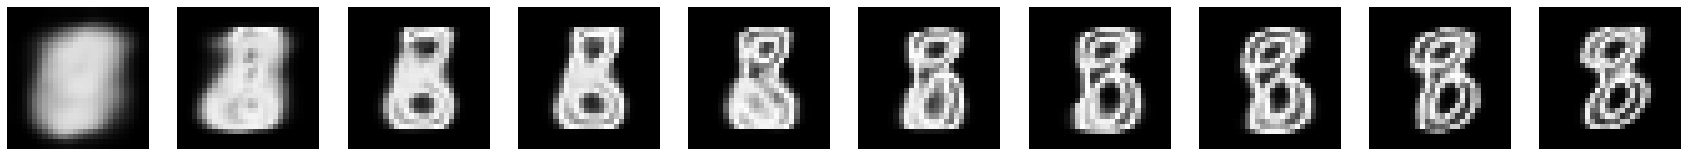

Step 6812, Loss (last minibatch): 0.278107225894928, Loss (80 step avg.): 0.22911561492048663


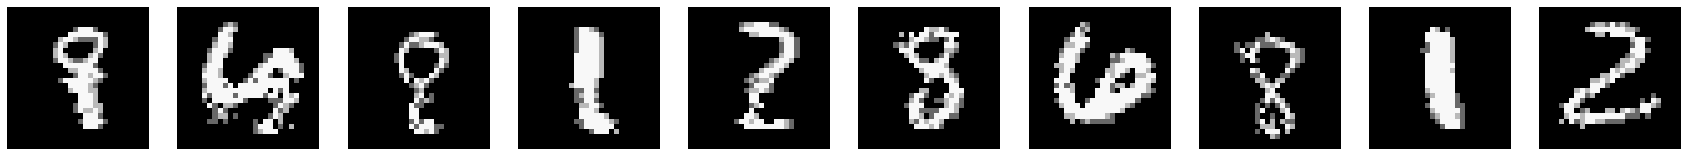

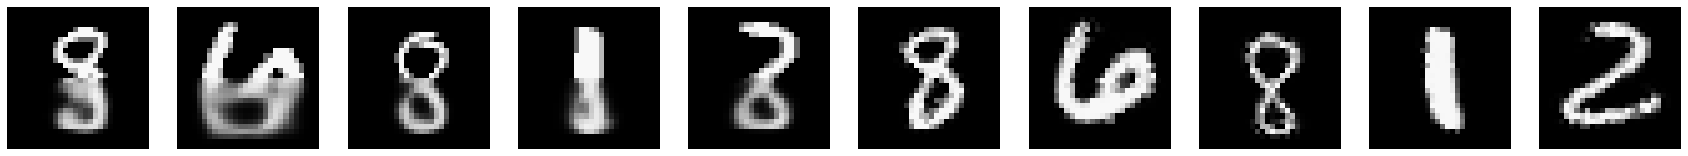

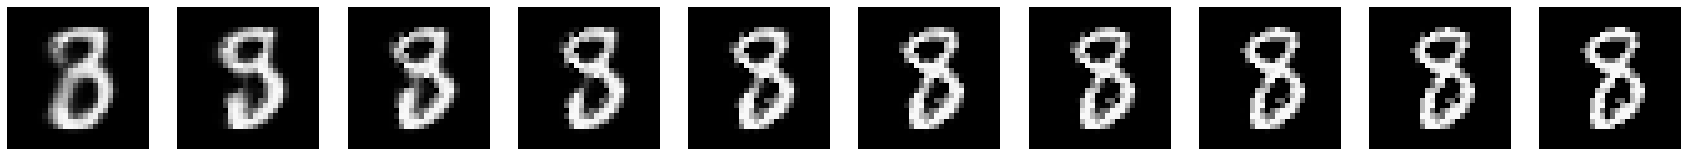

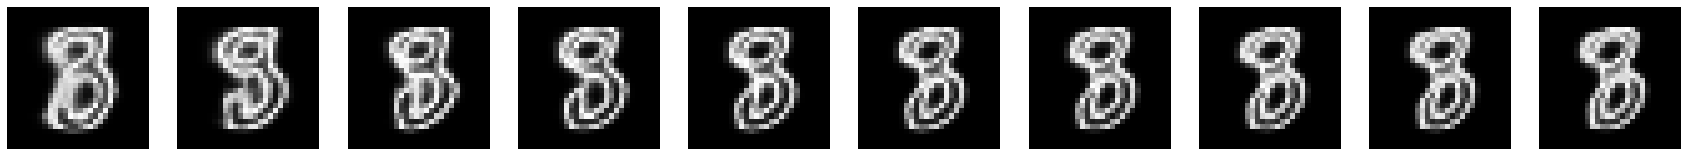

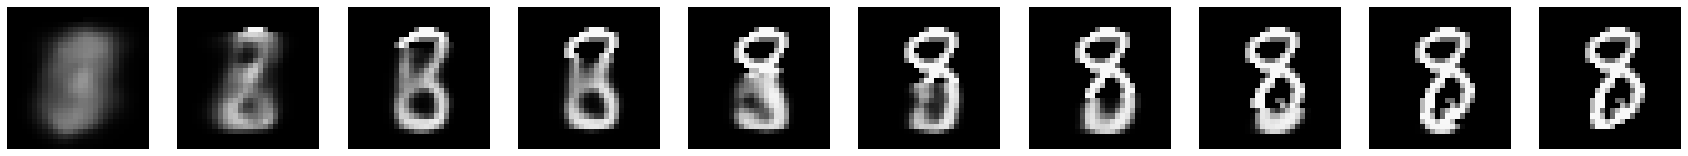

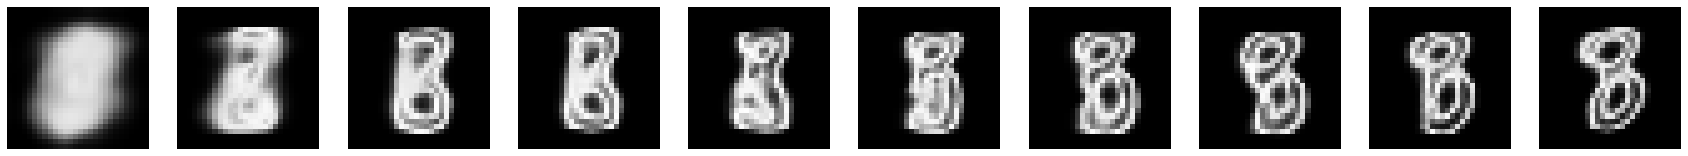

Step 7312, Loss (last minibatch): 0.23634499311447144, Loss (80 step avg.): 0.23663130696908927


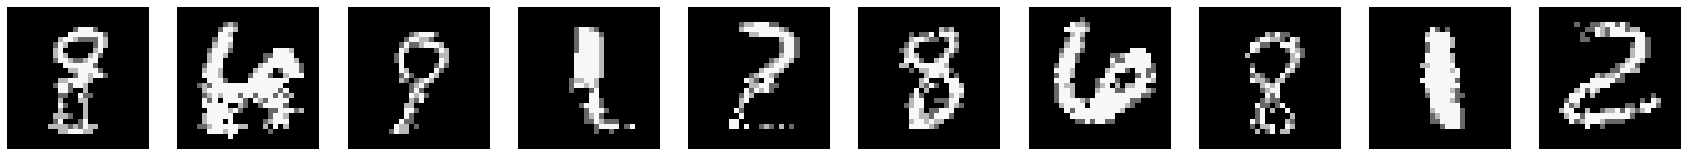

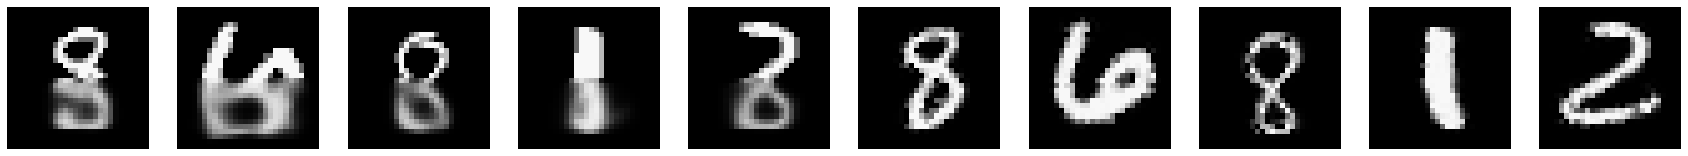

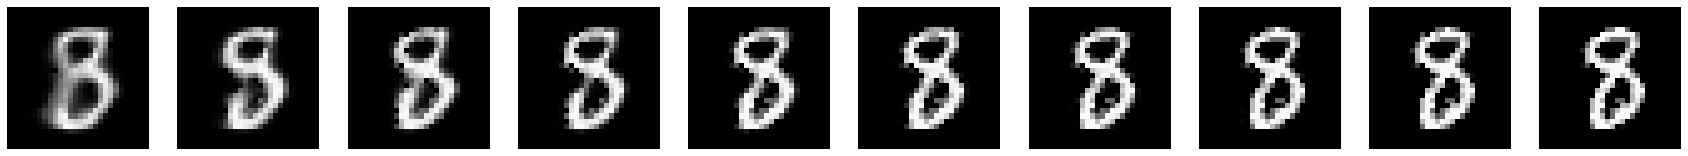

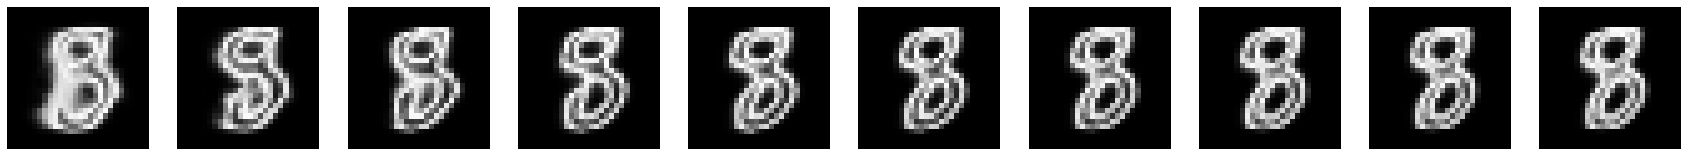

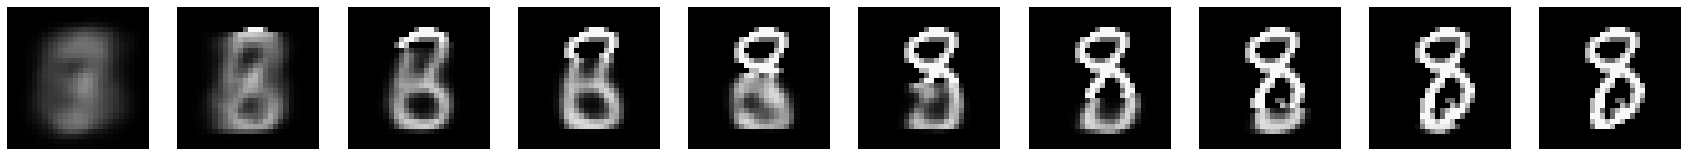

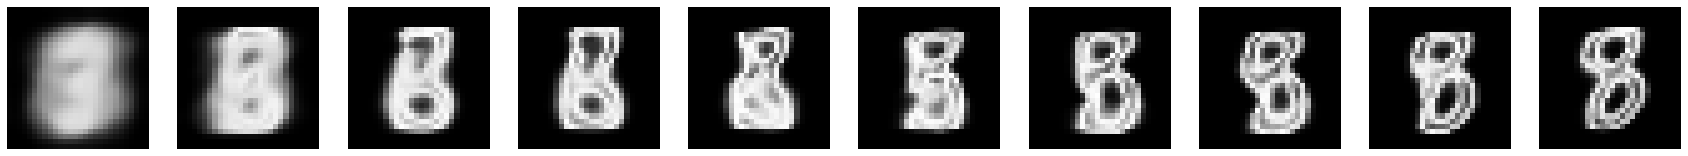

Step 7812, Loss (last minibatch): 0.2113906741142273, Loss (80 step avg.): 0.234813783639743


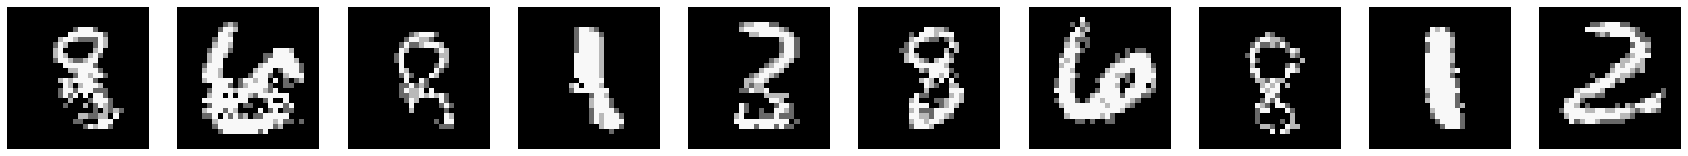

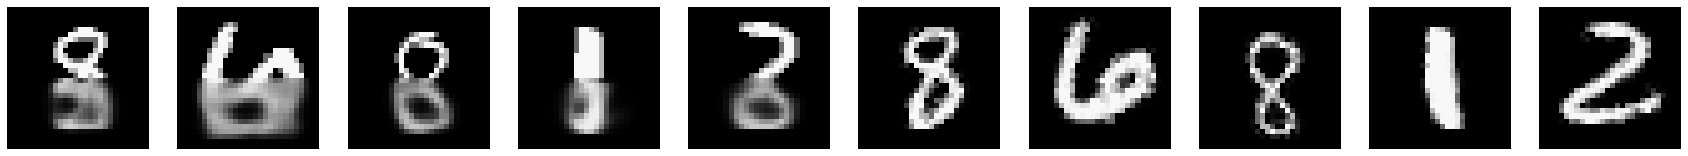

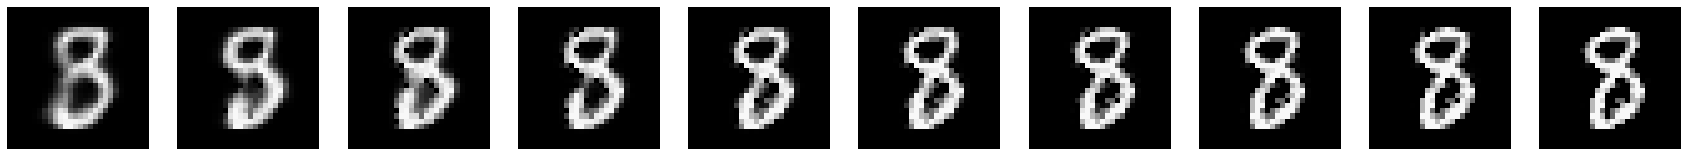

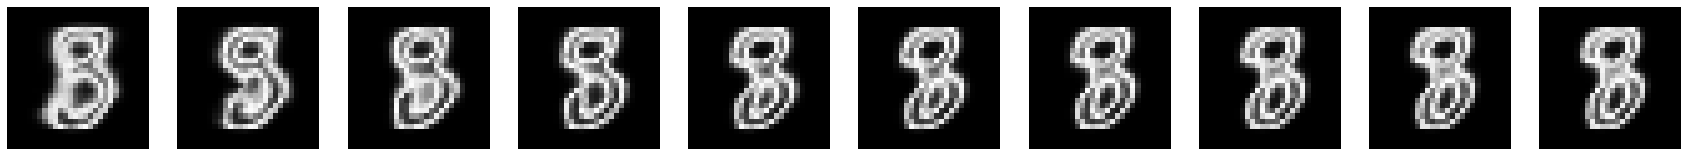

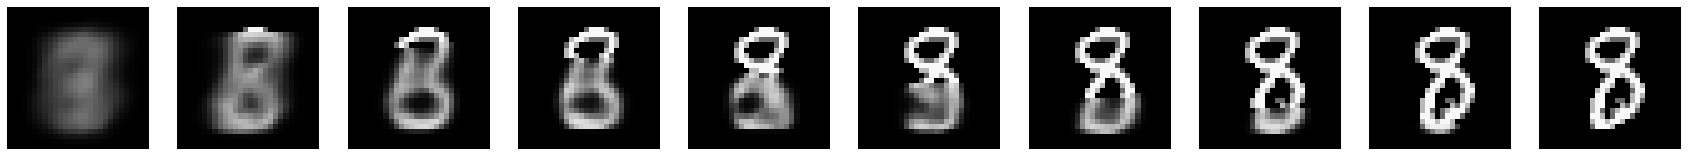

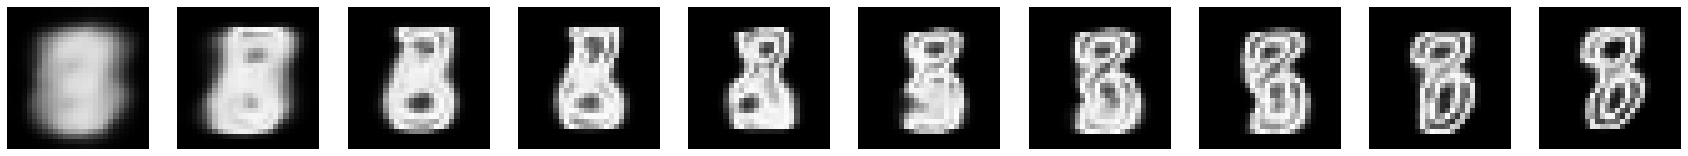

Step 8312, Loss (last minibatch): 0.1921766996383667, Loss (80 step avg.): 0.23000263100788917


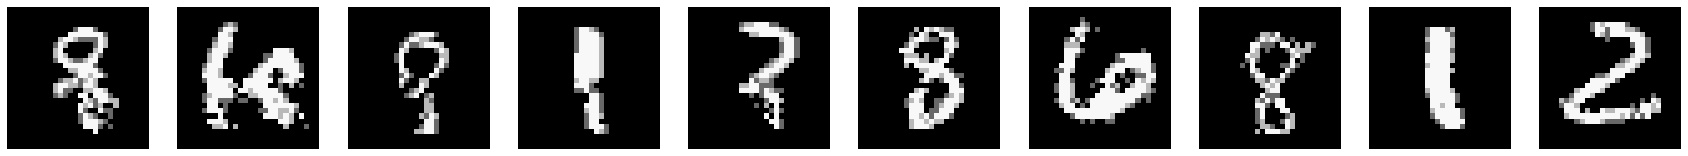

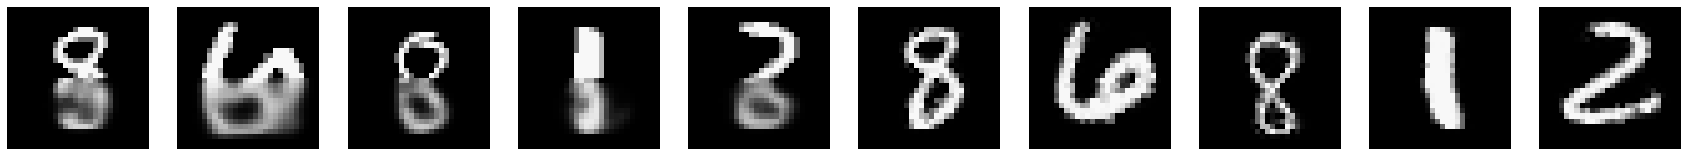

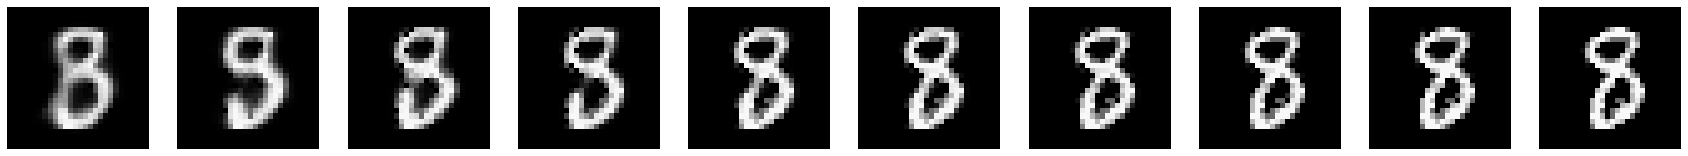

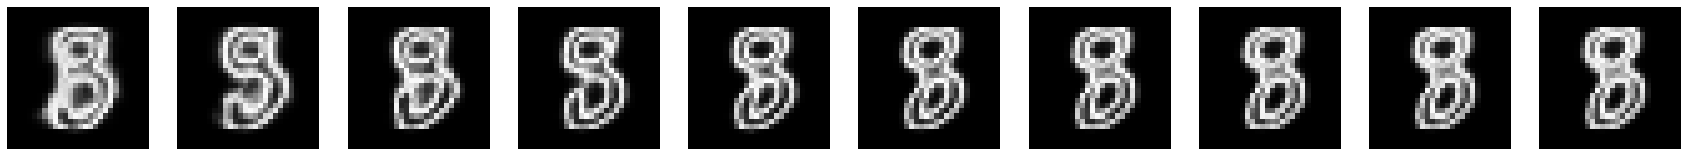

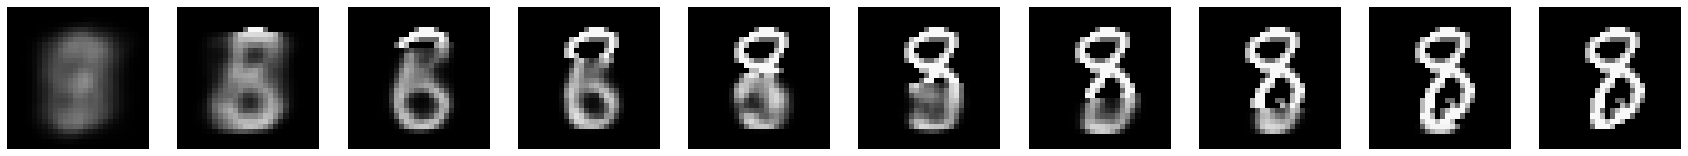

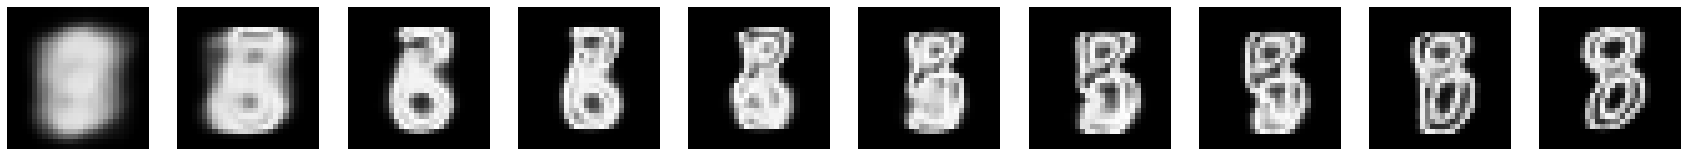

Step 8812, Loss (last minibatch): 0.31536412239074707, Loss (80 step avg.): 0.2279176182217068


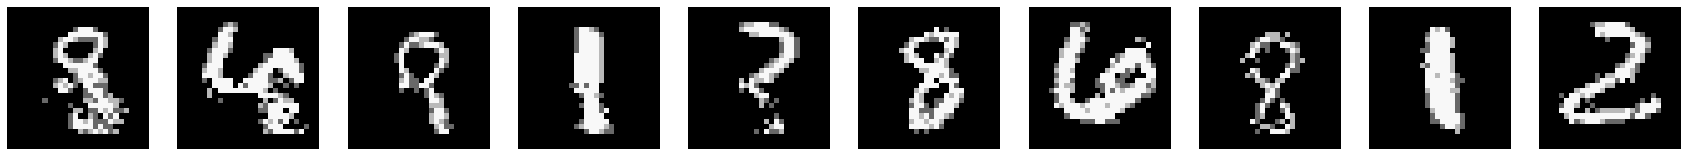

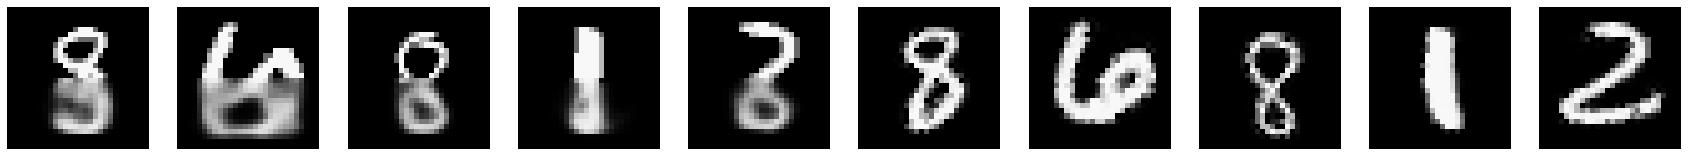

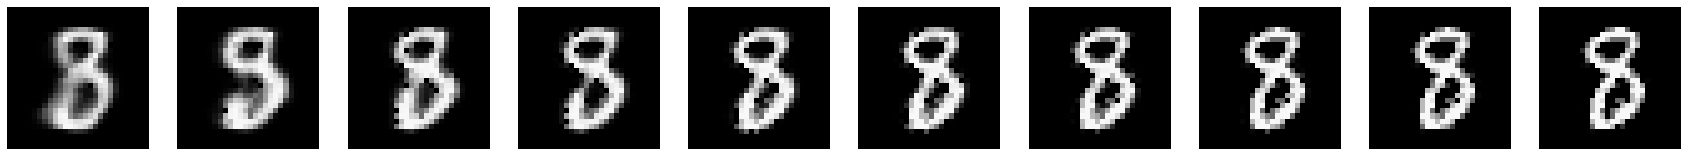

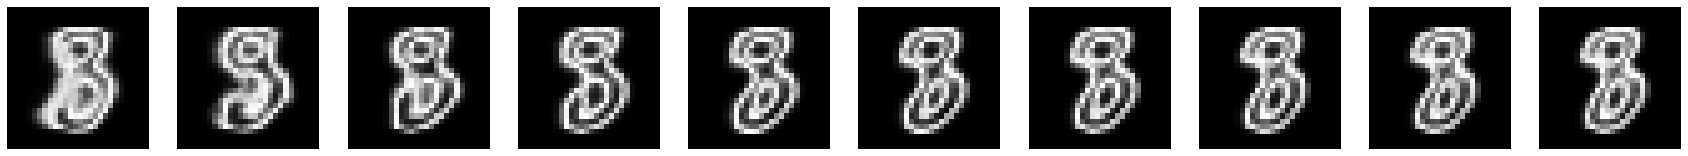

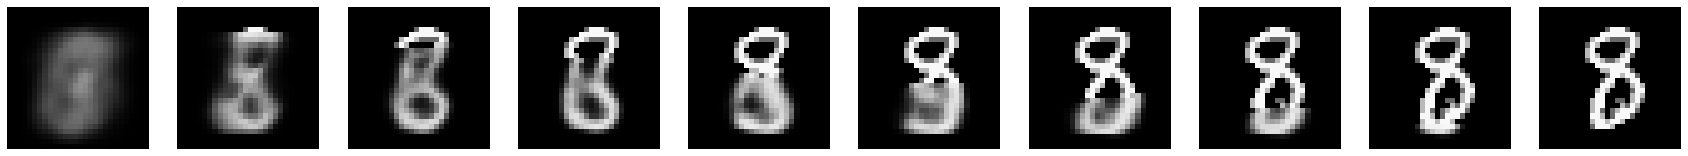

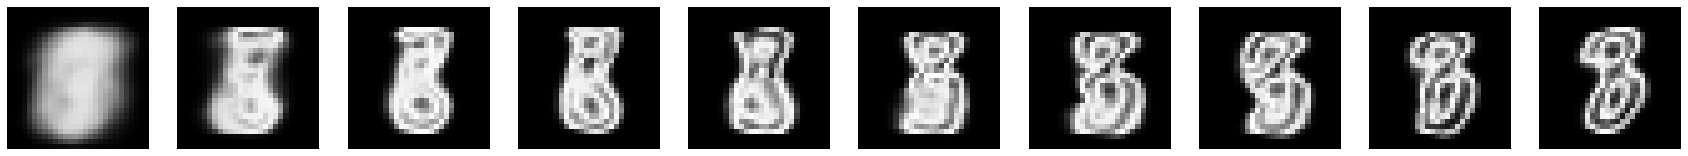

Step 9312, Loss (last minibatch): 0.23910276591777802, Loss (80 step avg.): 0.2188441815935535


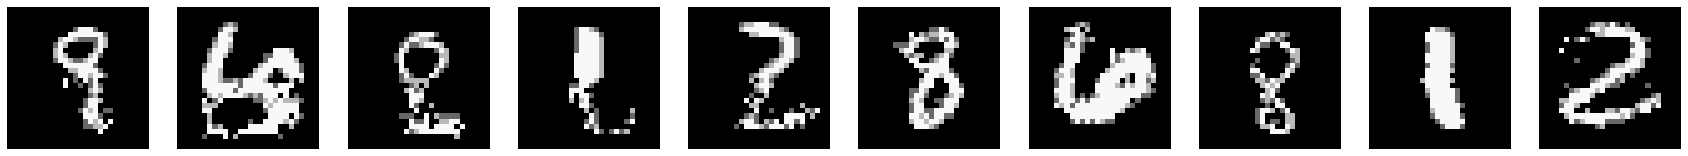

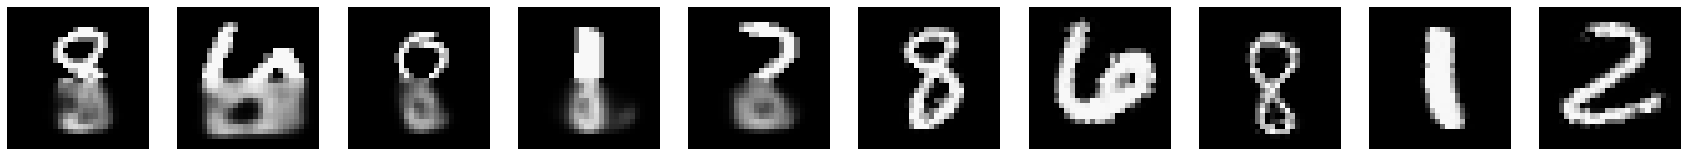

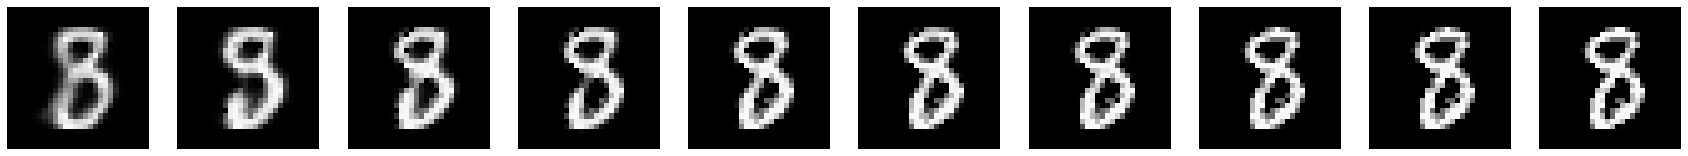

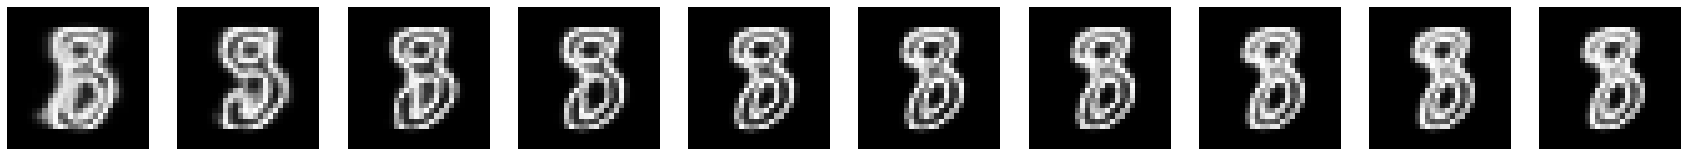

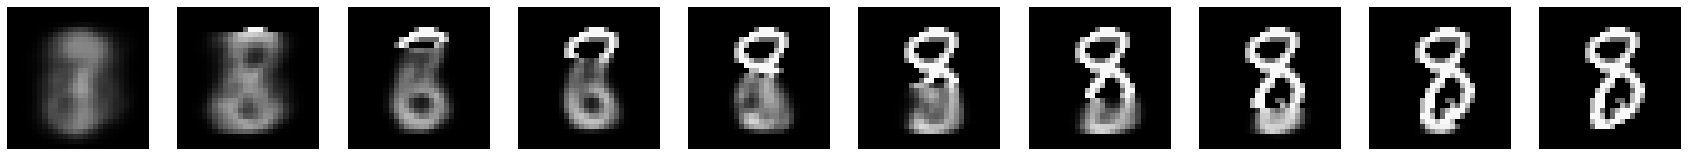

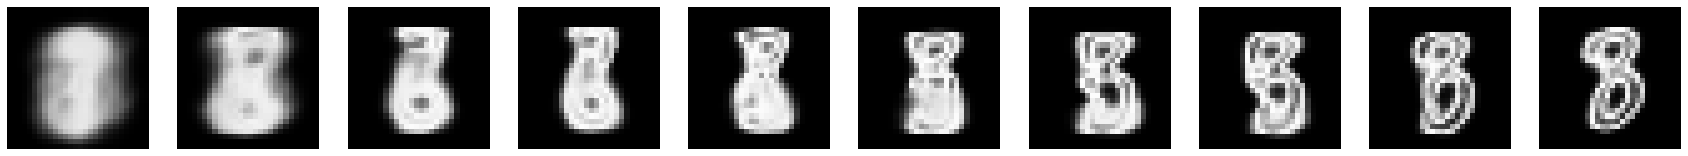

Step 9812, Loss (last minibatch): 0.20216336846351624, Loss (80 step avg.): 0.22483829546857764


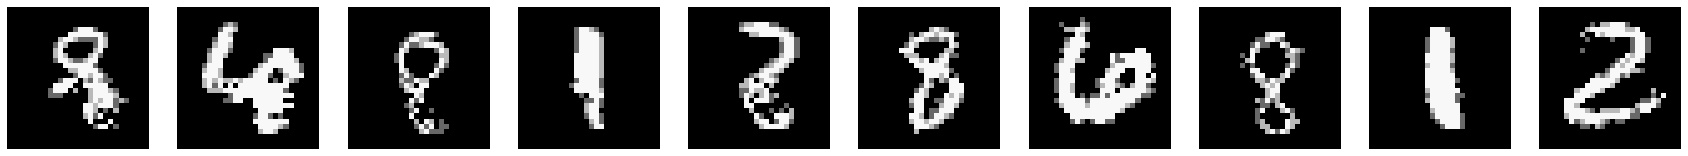

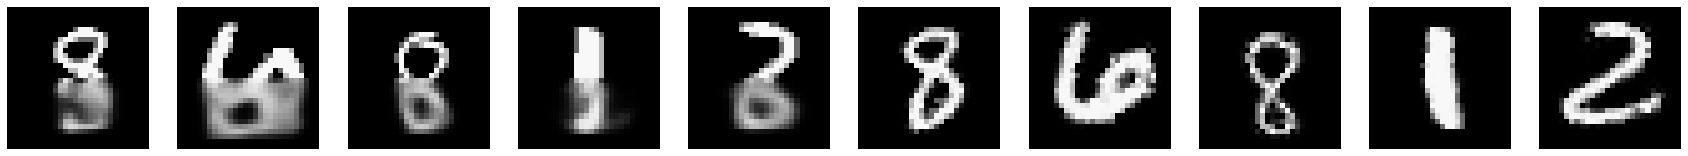

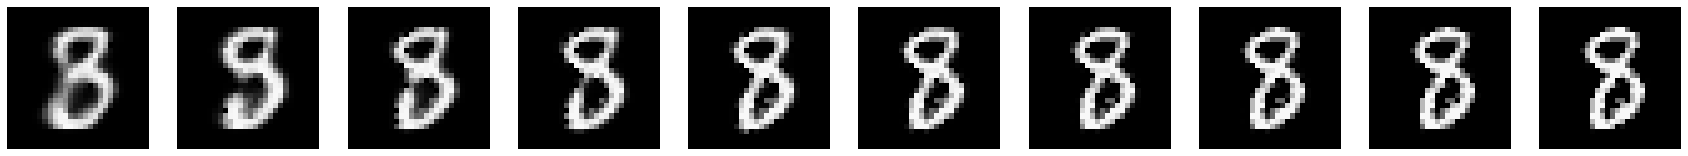

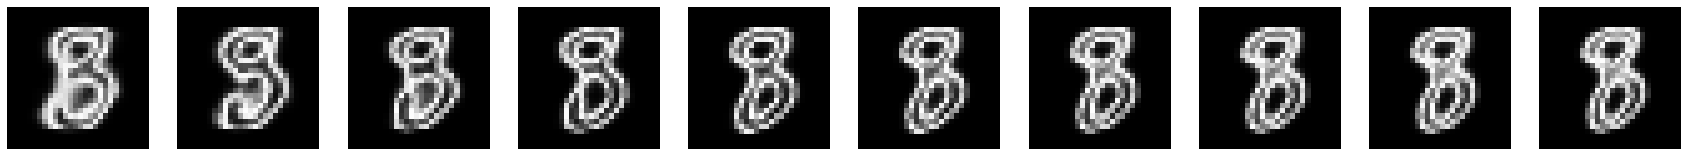

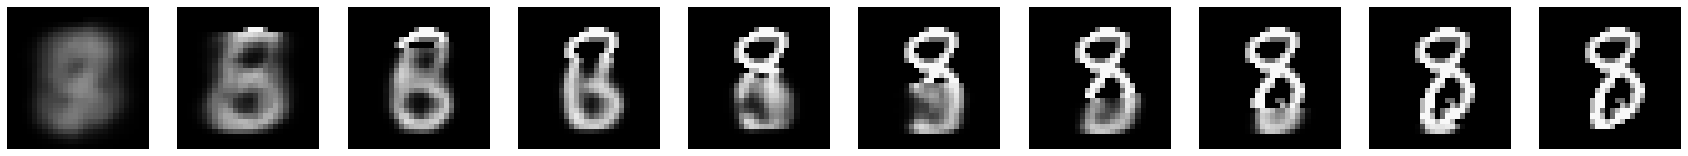

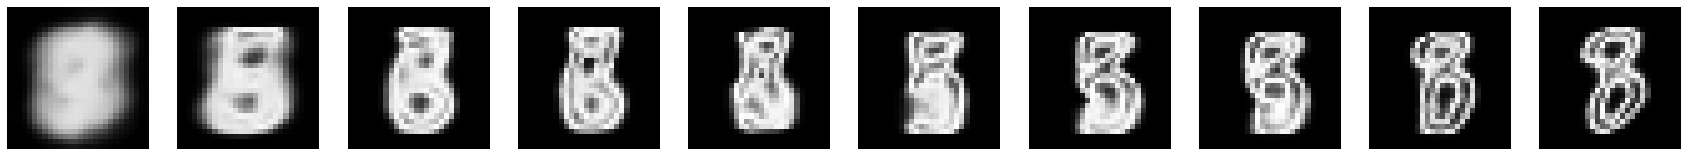

Step 10312, Loss (last minibatch): 0.27508026361465454, Loss (80 step avg.): 0.22511826915505492


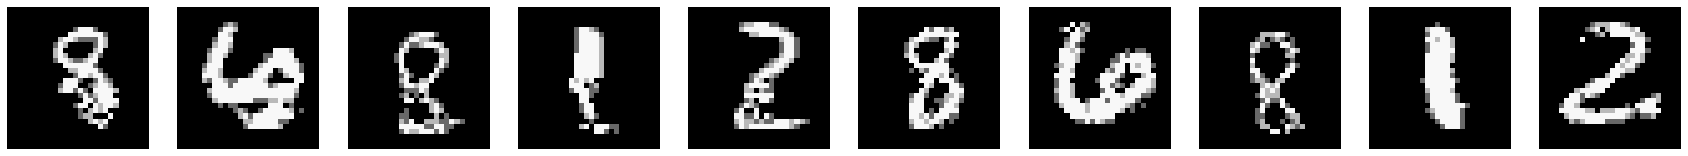

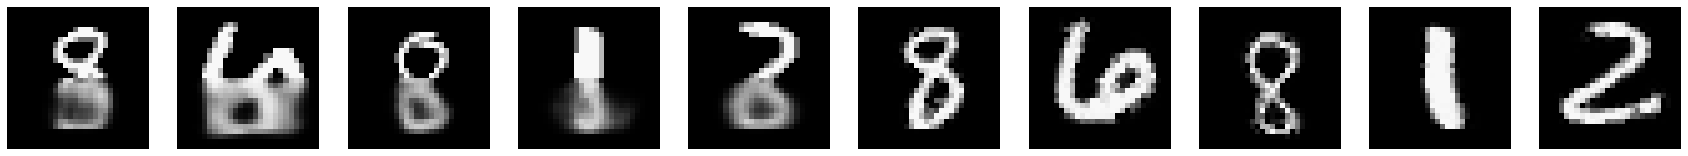

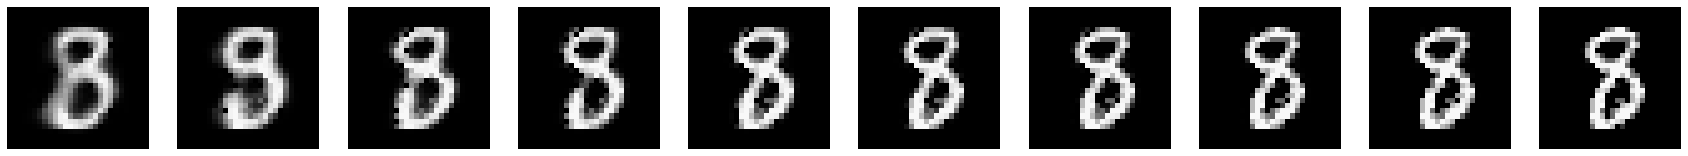

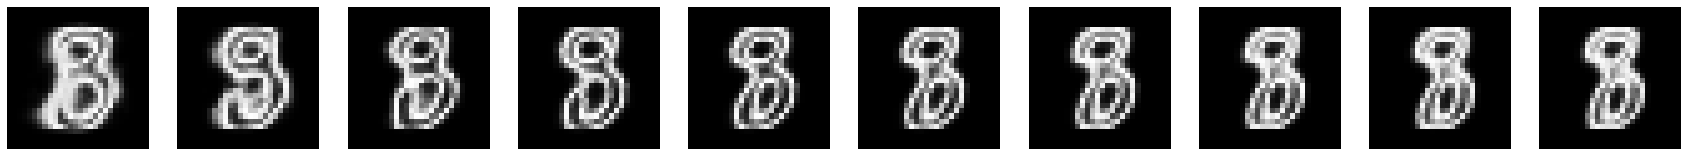

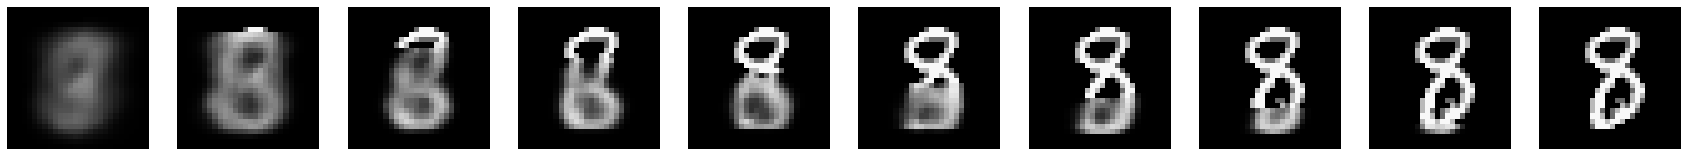

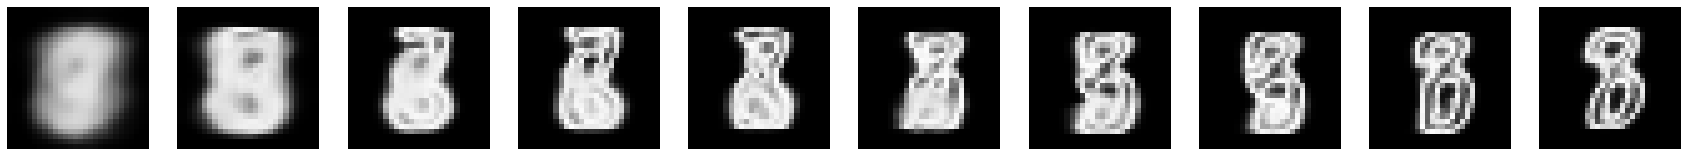

Step 10812, Loss (last minibatch): 0.2134898155927658, Loss (80 step avg.): 0.2097904901077718


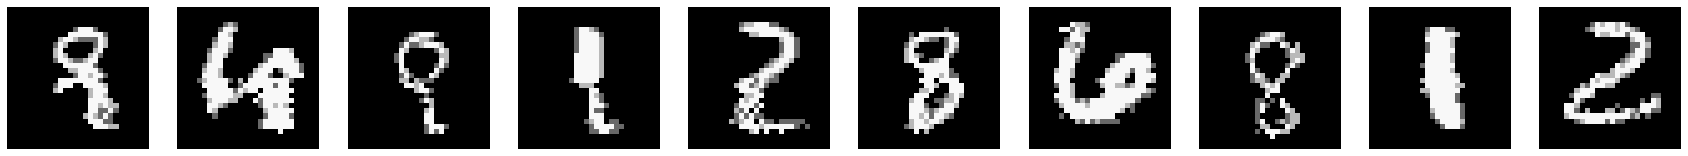

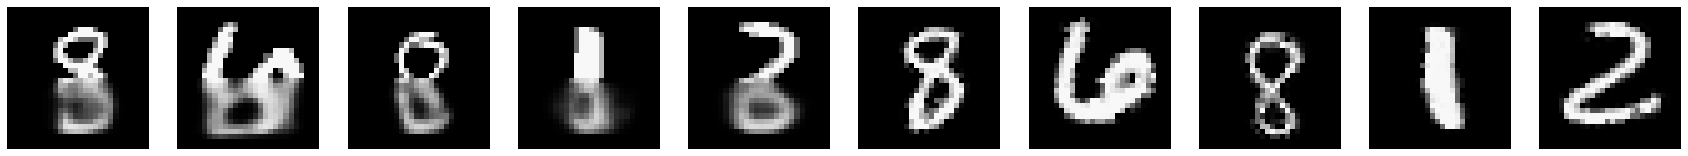

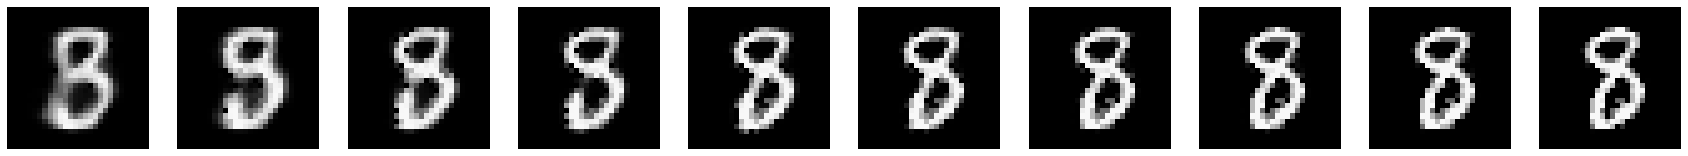

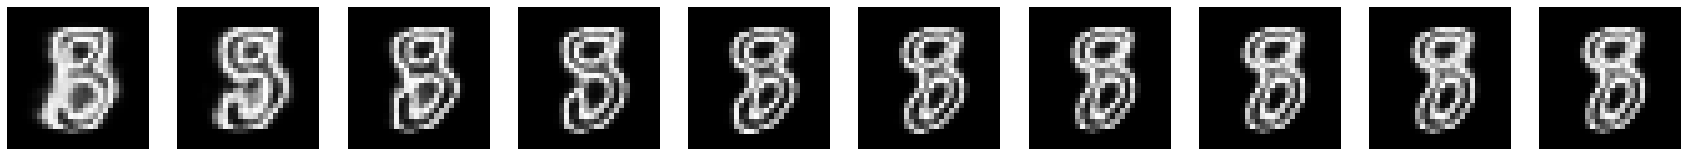

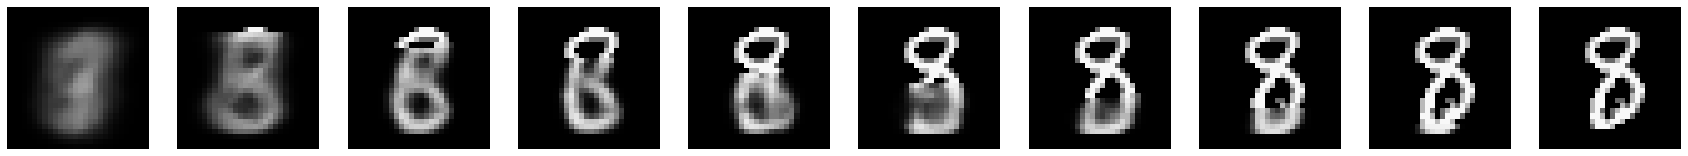

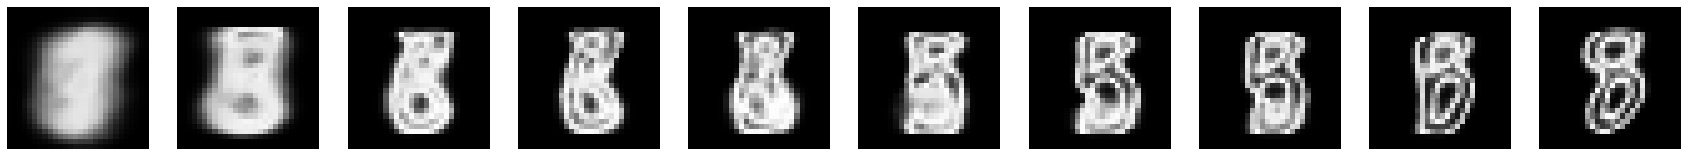

Step 11312, Loss (last minibatch): 0.2672950327396393, Loss (80 step avg.): 0.20955975924009157


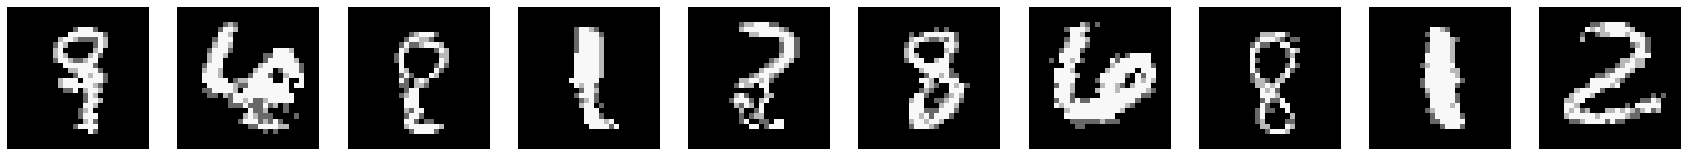

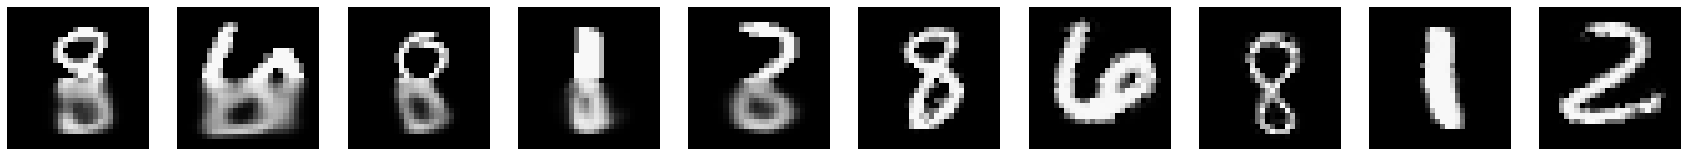

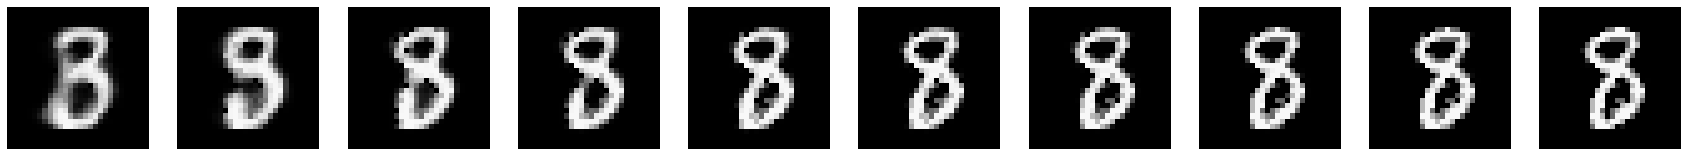

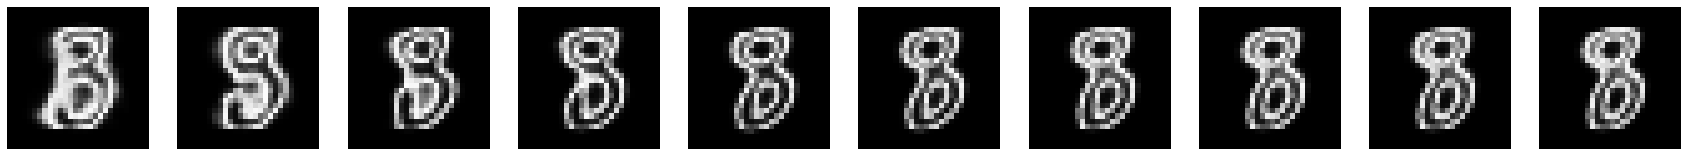

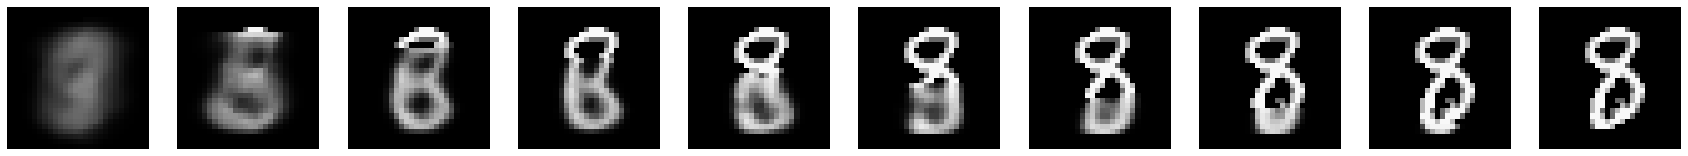

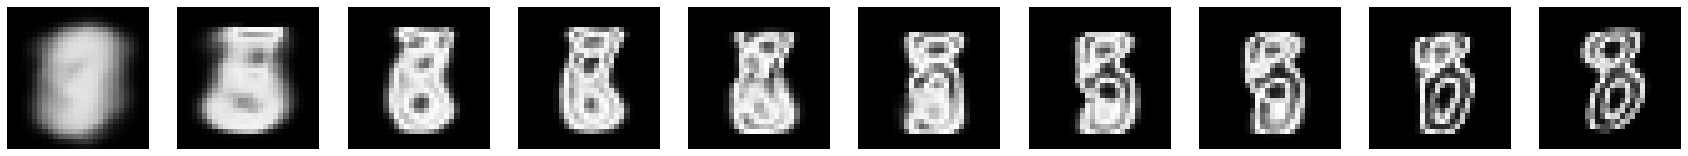

In [ ]:


with strategy.scope():
    training_loop.train()

In [ ]:
model.save(f"models/{model_name}")

In [ ]:
evaler.process_batch(show_input=True)
evaler.new_test_batch()
evaler.process_batch(show_input=True)

#### 